# 제품 이상여부 판별 프로젝트 (본선)


## 1. 데이터 불러오기


### 필수 라이브러리


In [1]:
!pip install hyperopt lightgbm

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import os
from pprint import pprint

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, StratifiedKFold
import lightgbm as lgb
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# 모든 열 출력
pd.set_option('display.max_columns', None)

### 데이터 읽어오기


In [4]:
ROOT_DIR = "data"
RANDOM_STATE = 110

# Load data
train_data = pd.read_csv(os.path.join(ROOT_DIR, "train.csv"))
train_data

,Wip Line_Dam,Process Desc._Dam,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,Collect Date_Dam,Insp. Seq No._Dam,Insp Judge Code_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION X Unit Time_Dam,CURE END POSITION X Judge Value_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Z Unit Time_Dam,CURE END POSITION Z Judge Value_Dam,CURE END POSITION Θ Collect Result_Dam,CURE END POSITION Θ Unit Time_Dam,CURE END POSITION Θ Judge Value_Dam,CURE SPEED Collect Result_Dam,CURE SPEED Unit Time_Dam,CURE SPEED Judge Value_Dam,CURE STANDBY POSITION X Collect Result_Dam,CURE STANDBY POSITION X Unit Time_Dam,CURE STANDBY POSITION X Judge Value_Dam,CURE STANDBY POSITION Z Collect Result_Dam,CURE STANDBY POSITION Z Unit Time_Dam,CURE STANDBY POSITION Z Judge Value_Dam,CURE STANDBY POSITION Θ Collect Result_Dam,CURE STANDBY POSITION Θ Unit Time_Dam,CURE STANDBY POSITION Θ Judge Value_Dam,CURE START POSITION X Collect Result_Dam,CURE START POSITION X Unit Time_Dam,CURE START POSITION X Judge Value_Dam,CURE START POSITION Z Collect Result_Dam,CURE START POSITION Z Unit Time_Dam,CURE START POSITION Z Judge Value_Dam,CURE START POSITION Θ Collect Result_Dam,CURE START POSITION Θ Unit Time_Dam,CURE START POSITION Θ Judge Value_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED SPEED OF RESIN Unit Time_Dam,DISCHARGED SPEED OF RESIN Judge Value_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Unit Time_Dam,DISCHARGED TIME OF RESIN(Stage1) Judge Value_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Unit Time_Dam,DISCHARGED TIME OF RESIN(Stage2) Judge Value_Dam,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage3) Unit Time_Dam,DISCHARGED TIME OF RESIN(Stage3) Judge Value_Dam,Dispense Volume(Stage1) Collect Result_Dam,Dispense Volume(Stage1) Unit Time_Dam,Dispense Volume(Stage1) Judge Value_Dam,Dispense Volume(Stage2) Collect Result_Dam,Dispense Volume(Stage2) Unit Time_Dam,Dispense Volume(Stage2) Judge Value_Dam,Dispense Volume(Stage3) Collect Result_Dam,Dispense Volume(Stage3) Unit Time_Dam,Dispense Volume(Stage3) Judge Value_Dam,HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage1) Unit Time_Dam,HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam,HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage2) Unit Time_Dam,HEAD NORMAL COORDINATE X AXIS(Stage2) Judge Value_Dam,HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage3) Unit Time_Dam,HEAD NORMAL COORDINATE X AXIS(Stage3) Judge Value_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage1) Unit Time_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage1) Judge Value_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage2) Unit Time_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage2) Judge Value_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage3) Unit Time_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage3) Judge Value_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage1) Unit Time_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage1) Judge Value_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage2) Unit Time_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage2) Judge Value_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage3) Unit Time_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage3) Judge Value_Dam,HEAD Standby Position X Collect Result_Dam,HEAD Standby Position X Unit Time_Dam,HEAD Standby Position X Judge Value_Dam,HEAD Standby Position Y Collect Result_Dam,HEAD Standby Position Y Unit Time_Dam,HEAD Standby Position Y Judge Value_Dam,HEAD Standby Position Z Collect Result_Dam,HEAD Standby Position Z Unit Time_Dam,HEAD Standby Position Z Jud

In [5]:
test = pd.read_csv(os.path.join(ROOT_DIR, "test.csv"))
test

,Set ID,Wip Line_Dam,Process Desc._Dam,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,Collect Date_Dam,Insp. Seq No._Dam,Insp Judge Code_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION X Unit Time_Dam,CURE END POSITION X Judge Value_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Z Unit Time_Dam,CURE END POSITION Z Judge Value_Dam,CURE END POSITION Θ Collect Result_Dam,CURE END POSITION Θ Unit Time_Dam,CURE END POSITION Θ Judge Value_Dam,CURE SPEED Collect Result_Dam,CURE SPEED Unit Time_Dam,CURE SPEED Judge Value_Dam,CURE STANDBY POSITION X Collect Result_Dam,CURE STANDBY POSITION X Unit Time_Dam,CURE STANDBY POSITION X Judge Value_Dam,CURE STANDBY POSITION Z Collect Result_Dam,CURE STANDBY POSITION Z Unit Time_Dam,CURE STANDBY POSITION Z Judge Value_Dam,CURE STANDBY POSITION Θ Collect Result_Dam,CURE STANDBY POSITION Θ Unit Time_Dam,CURE STANDBY POSITION Θ Judge Value_Dam,CURE START POSITION X Collect Result_Dam,CURE START POSITION X Unit Time_Dam,CURE START POSITION X Judge Value_Dam,CURE START POSITION Z Collect Result_Dam,CURE START POSITION Z Unit Time_Dam,CURE START POSITION Z Judge Value_Dam,CURE START POSITION Θ Collect Result_Dam,CURE START POSITION Θ Unit Time_Dam,CURE START POSITION Θ Judge Value_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED SPEED OF RESIN Unit Time_Dam,DISCHARGED SPEED OF RESIN Judge Value_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Unit Time_Dam,DISCHARGED TIME OF RESIN(Stage1) Judge Value_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Unit Time_Dam,DISCHARGED TIME OF RESIN(Stage2) Judge Value_Dam,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage3) Unit Time_Dam,DISCHARGED TIME OF RESIN(Stage3) Judge Value_Dam,Dispense Volume(Stage1) Collect Result_Dam,Dispense Volume(Stage1) Unit Time_Dam,Dispense Volume(Stage1) Judge Value_Dam,Dispense Volume(Stage2) Collect Result_Dam,Dispense Volume(Stage2) Unit Time_Dam,Dispense Volume(Stage2) Judge Value_Dam,Dispense Volume(Stage3) Collect Result_Dam,Dispense Volume(Stage3) Unit Time_Dam,Dispense Volume(Stage3) Judge Value_Dam,HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage1) Unit Time_Dam,HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam,HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage2) Unit Time_Dam,HEAD NORMAL COORDINATE X AXIS(Stage2) Judge Value_Dam,HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage3) Unit Time_Dam,HEAD NORMAL COORDINATE X AXIS(Stage3) Judge Value_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage1) Unit Time_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage1) Judge Value_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage2) Unit Time_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage2) Judge Value_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage3) Unit Time_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage3) Judge Value_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage1) Unit Time_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage1) Judge Value_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage2) Unit Time_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage2) Judge Value_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage3) Unit Time_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage3) Judge Value_Dam,HEAD Standby Position X Collect Result_Dam,HEAD Standby Position X Unit Time_Dam,HEAD Standby Position X Judge Value_Dam,HEAD Standby Position Y Collect Result_Dam,HEAD Standby Position Y Unit Time_Dam,HEAD Standby Position Y Judge Value_Dam,HEAD Standby Position Z Collect Result_Dam,HEAD Standby Position Z Unit Time_Dam,HEAD Standby Positio

## 2. 수기 데이터 읽어오기

수기 데이터는 제조 환경과 관련된 정보들이 담겨있는 데이터입니다.

In [6]:
df_hand = pd.read_excel(os.path.join(ROOT_DIR, "hand_data.xlsx"))
df_hand

,day,start_time,end_time,Dam Thickness - 1time / day,Fill thickness - 1time / day,Fill cure energy (mJ) - Every break time,Fill cure power (mW) - Every break time,Line Temp. - Every break time,Line humidity - Every break time,OCR gap - Line#1 stage1,OCR gap - Line#1 stage2,OCR gap - Line#1 stage3,OCR gap - Line #2 stage1,OCR gap - Line #2 stage2,OCR gap - Line #2 stage3
0,240319,08:00:00,10:30:00,454.0,193.0,1728.0,2919.0,23.4,56.6,1.2,1.000,1.200,1.2,0.900,1.4
1,240319,10:45:00,12:00:00,454.0,193.0,1754.0,2962.0,24.0,50.9,1.2,1.000,1.200,1.2,0.900,1.4
2,240319,13:00:00,15:00:00,454.0,193.0,1708.0,2887.0,24.5,49.6,1.2,1.000,1.200,1.2,0.900,1.4
3,240319,15:15:00,18:00:00,454.0,193.0,1751.0,2946.0,24.7,53.4,1.2,1.000,1.200,1.2,1.200,1.4
4,240319,18:30:00,20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,240428,08:00:00,10:30:00,478.0,232.0,1642.0,2952.0,24.6,53.0,1.0,1.232,1.466,1.2,1.167,1.5
101,240428,10:45:00,12:00:00,478.0,232.0,1679.0,2942.0,24.8,52.7,1.0,1.232,1.466,1.2,1.167,1.5
102,240428,13:00:00,15:00:00,478.0,232.0,1552.0,2941.0,24.6,55.5,1.0,1.232,1.466,1.2,1.167,1.5
103,240428,15:15:00,18:00:00,478.0,232.0,1552.0,2934.0,24.3,54.6,1.0,1.232,1.466,1.2,1.167,1.5


In [7]:
drop_col=[]
for col in train_data.columns:
  nullcount = train_data[col].isnull().sum()
  nunique = train_data[col].nunique()
  if nullcount == len(train_data):
    drop_col.append(col)
  if (nunique==1) & (nullcount == 0):
    drop_col.append(col)
    
train_data = train_data.drop(drop_col, axis=1)
test = test.drop(drop_col, axis=1)


train_data

,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,Collect Date_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE START POSITION X Collect Result_Dam,CURE START POSITION Θ Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam,Dispense Volume(Stage1) Collect Result_Dam,Dispense Volume(Stage2) Collect Result_Dam,Dispense Volume(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam,HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam,HEAD Standby Position X Collect Result_Dam,HEAD Standby Position Y Collect Result_Dam,HEAD Standby Position Z Collect Result_Dam,Head Clean Position X Collect Result_Dam,Head Clean Position Y Collect Result_Dam,Head Clean Position Z Collect Result_Dam,Head Purge Position X Collect Result_Dam,Head Purge Position Y Collect Result_Dam,Head Purge Position Z Collect Result_Dam,Head Zero Position X Collect Result_Dam,Head Zero Position Y Collect Result_Dam,Head Zero Position Z Collect Result_Dam,Machine Tact time Collect Result_Dam,PalletID Collect Result_Dam,Production Qty Collect Result_Dam,Receip No Collect Result_Dam,Stage1 Circle1 Distance Speed Collect Result_Dam,Stage1 Circle2 Distance Speed Collect Result_Dam,Stage1 Circle3 Distance Speed Collect Result_Dam,Stage1 Circle4 Distance Speed Collect Result_Dam,Stage1 Line1 Distance Speed Collect Result_Dam,Stage1 Line2 Distance Speed Collect Result_Dam,Stage1 Line3 Distance Speed Collect Result_Dam,Stage1 Line4 Distance Speed Collect Result_Dam,Stage2 Circle1 Distance Speed Collect Result_Dam,Stage2 Circle2 Distance Speed Collect Result_Dam,Stage2 Circle3 Distance Speed Collect Result_Dam,Stage2 Circle4 Distance Speed Collect Result_Dam,Stage2 Line1 Distance Speed Collect Result_Dam,Stage2 Line2 Distance Speed Collect Result_Dam,Stage2 Line3 Distance Speed Collect Result_Dam,Stage2 Line4 Distance Speed Collect Result_Dam,Stage3 Circle1 Distance Speed Collect Result_Dam,Stage3 Circle2 Distance Speed Collect Result_Dam,Stage3 Circle3 Distance Speed Collect Result_Dam,Stage3 Circle4 Distance Speed Collect Result_Dam,Stage3 Line1 Distance Speed Collect Result_Dam,Stage3 Line2 Distance Speed Collect Result_Dam,Stage3 Line3 Distance Speed Collect Result_Dam,Stage3 Line4 Distance Speed Collect Result_Dam,THICKNESS 1 Collect Result_Dam,THICKNESS 2 Collect Result_Dam,THICKNESS 3 Collect Result_Dam,WorkMode Collect Result_Dam,Model.Suffix_AutoClave,Workorder_AutoClave,Collect Date_AutoClave,1st Pressure Collect Result_AutoClave,1st Pressure 1st Pressure Unit Time_AutoClave,2nd Pressure Collect Result_AutoClave,2nd Pressure Unit Time_AutoClave,3rd Pressure Collect Result_AutoClave,3rd Pressure Unit Time_AutoClave,Chamber Temp. Collect Result_AutoClave,Chamber Temp. Unit Time_AutoClave,Chamber Temp. Judge Value_AutoClave,GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave,GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave,Equipment_Fill1,Model.Suffix_Fill1,Workorder_Fill1,Collect Date_Fill1,DISCHARGED SPEED OF RESIN Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1,Dispense Volume(Stage1) Collect Result_Fill1,Dispense Volume(Stage2) Collect Result_Fill1,Dispense Volume(Stage3) Collect Result_Fil

In [8]:
cols=["Model.Suffix_Dam","Model.Suffix_AutoClave","Model.Suffix_Fill1","Model.Suffix_Fill2"]

train_data["Model.Suffix"]= train_data["Model.Suffix_Dam"]
train_data = train_data.drop(cols, axis=1)

cols=["Model.Suffix_Dam","Model.Suffix_AutoClave","Model.Suffix_Fill1","Model.Suffix_Fill2"]

test["Model.Suffix"]= test["Model.Suffix_Dam"]
test = test.drop(cols, axis=1)


cols=["Workorder_Dam","Workorder_AutoClave","Workorder_Fill1","Workorder_Fill2"]

train_data["Workorder"]= train_data["Workorder_Dam"]
train_data = train_data.drop(cols, axis=1)

cols=["Workorder_Dam","Workorder_AutoClave","Workorder_Fill1","Workorder_Fill2"]

test["Workorder"]= test["Workorder_Dam"]
test = test.drop(cols, axis=1)


In [9]:
train_data

,Equipment_Dam,Collect Date_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE START POSITION X Collect Result_Dam,CURE START POSITION Θ Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam,Dispense Volume(Stage1) Collect Result_Dam,Dispense Volume(Stage2) Collect Result_Dam,Dispense Volume(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam,HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam,HEAD Standby Position X Collect Result_Dam,HEAD Standby Position Y Collect Result_Dam,HEAD Standby Position Z Collect Result_Dam,Head Clean Position X Collect Result_Dam,Head Clean Position Y Collect Result_Dam,Head Clean Position Z Collect Result_Dam,Head Purge Position X Collect Result_Dam,Head Purge Position Y Collect Result_Dam,Head Purge Position Z Collect Result_Dam,Head Zero Position X Collect Result_Dam,Head Zero Position Y Collect Result_Dam,Head Zero Position Z Collect Result_Dam,Machine Tact time Collect Result_Dam,PalletID Collect Result_Dam,Production Qty Collect Result_Dam,Receip No Collect Result_Dam,Stage1 Circle1 Distance Speed Collect Result_Dam,Stage1 Circle2 Distance Speed Collect Result_Dam,Stage1 Circle3 Distance Speed Collect Result_Dam,Stage1 Circle4 Distance Speed Collect Result_Dam,Stage1 Line1 Distance Speed Collect Result_Dam,Stage1 Line2 Distance Speed Collect Result_Dam,Stage1 Line3 Distance Speed Collect Result_Dam,Stage1 Line4 Distance Speed Collect Result_Dam,Stage2 Circle1 Distance Speed Collect Result_Dam,Stage2 Circle2 Distance Speed Collect Result_Dam,Stage2 Circle3 Distance Speed Collect Result_Dam,Stage2 Circle4 Distance Speed Collect Result_Dam,Stage2 Line1 Distance Speed Collect Result_Dam,Stage2 Line2 Distance Speed Collect Result_Dam,Stage2 Line3 Distance Speed Collect Result_Dam,Stage2 Line4 Distance Speed Collect Result_Dam,Stage3 Circle1 Distance Speed Collect Result_Dam,Stage3 Circle2 Distance Speed Collect Result_Dam,Stage3 Circle3 Distance Speed Collect Result_Dam,Stage3 Circle4 Distance Speed Collect Result_Dam,Stage3 Line1 Distance Speed Collect Result_Dam,Stage3 Line2 Distance Speed Collect Result_Dam,Stage3 Line3 Distance Speed Collect Result_Dam,Stage3 Line4 Distance Speed Collect Result_Dam,THICKNESS 1 Collect Result_Dam,THICKNESS 2 Collect Result_Dam,THICKNESS 3 Collect Result_Dam,WorkMode Collect Result_Dam,Collect Date_AutoClave,1st Pressure Collect Result_AutoClave,1st Pressure 1st Pressure Unit Time_AutoClave,2nd Pressure Collect Result_AutoClave,2nd Pressure Unit Time_AutoClave,3rd Pressure Collect Result_AutoClave,3rd Pressure Unit Time_AutoClave,Chamber Temp. Collect Result_AutoClave,Chamber Temp. Unit Time_AutoClave,Chamber Temp. Judge Value_AutoClave,GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave,GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave,Equipment_Fill1,Collect Date_Fill1,DISCHARGED SPEED OF RESIN Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1,Dispense Volume(Stage1) Collect Result_Fill1,Dispense Volume(Stage2) Collect Result_Fill1,Dispense Volume(Stage3) Collect Result_Fill1,HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1,HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Val

In [10]:
train_head=[]
# 그룹핑
for column in train_data.columns:
  if 'head' in column.lower():
    train_head.append(column)
train_head_data=train_data[train_head]
    

In [11]:
train_head_data

,HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam,HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam,HEAD Standby Position X Collect Result_Dam,HEAD Standby Position Y Collect Result_Dam,HEAD Standby Position Z Collect Result_Dam,Head Clean Position X Collect Result_Dam,Head Clean Position Y Collect Result_Dam,Head Clean Position Z Collect Result_Dam,Head Purge Position X Collect Result_Dam,Head Purge Position Y Collect Result_Dam,Head Purge Position Z Collect Result_Dam,Head Zero Position X Collect Result_Dam,Head Zero Position Y Collect Result_Dam,Head Zero Position Z Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1,HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill1,HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1,HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1,HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1,HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1,HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1,HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1,HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1,HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1,HEAD Standby Position X Collect Result_Fill1,HEAD Standby Position Y Collect Result_Fill1,HEAD Standby Position Z Collect Result_Fill1,Head Clean Position X Collect Result_Fill1,Head Clean Position Y Collect Result_Fill1,Head Clean Position Z Collect Result_Fill1,Head Purge Position X Collect Result_Fill1,Head Purge Position Y Collect Result_Fill1,Head Purge Position Z Collect Result_Fill1,HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2,HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill2,HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2,HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2,HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill2,HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2,HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2,HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2,HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2,HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2,HEAD Standby Position X Collect Result_Fill2,HEAD Standby Position Y Collect Result_Fill2,HEAD Standby Position Z Collect Result_Fill2,Head Clean Position X Collect Result_Fill2,Head Clean Position Y Collect Result_Fill2,Head Clean Position Z Collect Result_Fill2,Head Purge Position X Collect Result_Fill2,Head Purge Position Y Collect Result_Fill2,Head Purge Position Z Collect Result_Fill2
0,NaN,NaN,550.5,464.3,161.4,384.0,383.1,384.00,274.51,274.51,274.51,257,66,0.0,127.5,66.00,124.0,257,66.00,130.85,505.0,300.0,NaN,NaN,838.4,458.7,157.0,430.0,429.8,430.3,244.520,244.520,244.520,289,50,0.0,123.4,50.0,92.2,289,50,NaN,NaN,835.5,458.0,156.0,428.0,427.9,428.0,243.7,243.7,243.7,270,50,-10,119,50.0,91.8,270,50
1,550.3,NaN,463.8,160.8,377.3,377.3,377.3,282.15,282.15,282.15,257.00,66,0,127.5,66.0,130.85,257.0,66,130.85,505.00,300.0,265.0,838.4,NaN,458.5,157.0,430.5,430.5,430.8,244.4,244.400,244.400,289.000,50,0,123.4,50.0,92.2,289.0,50,145,835.5,NaN,458.0,156.0,428.0,427.9,428.0,243.7,243.7,243.7,270.0,50,-10,119,50,91.8,270.0,50,85
2,OK,OK,162.4,465.4,551.7,1271.8,1383.9,1271.80,274.33,274.33,274.33,257,66,0.0,127.5,66.00,124.0,257,66.00,130.85,505.0,300.0,OK,OK,837.9,458.1,156.1,1323.5,1322.5,1323.1,244.415,244.415,244.415,289,50,0.0,123.4,50.0,92.2,289,50,OK,OK,305.0,499.8,694.0,1324.2,1324.2,1324.2,243.5,243.5,243.5,270,50,-10,119,50.0,91.8,270,50
3,1

In [12]:
nan_data=['HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam',
'GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave',
'GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave',
'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill1',
'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill2',]
nanana=train_data[nan_data]

In [13]:
# 첫 번째 컬럼을 기준으로 나머지 컬럼들과 비교
first_col = nanana.iloc[:, 0]
comparison_results = {}

# 각 컬럼에 대해 비교 결과 저장
for col in nanana.columns[1:]:
    comparison_results[col] = first_col.equals(nanana[col])

# 결과 출력
for col, is_equal in comparison_results.items():
    if is_equal:
        train_data=train_data.drop(col, axis=1)
        test=test.drop(col,axis=1)
        print(f"컬럼 '{nan_data[0]}'와 컬럼 '{col}'는 동일합니다.")
    else:
        print(f"컬럼 '{nan_data[0]}'와 컬럼 '{col}'는 다릅니다.")


컬럼 'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam'와 컬럼 'GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave'는 동일합니다.
컬럼 'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam'와 컬럼 'GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave'는 동일합니다.
컬럼 'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam'와 컬럼 'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill1'는 동일합니다.
컬럼 'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam'와 컬럼 'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill2'는 동일합니다.


In [14]:
train_data

,Equipment_Dam,Collect Date_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE START POSITION X Collect Result_Dam,CURE START POSITION Θ Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam,Dispense Volume(Stage1) Collect Result_Dam,Dispense Volume(Stage2) Collect Result_Dam,Dispense Volume(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam,HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam,HEAD Standby Position X Collect Result_Dam,HEAD Standby Position Y Collect Result_Dam,HEAD Standby Position Z Collect Result_Dam,Head Clean Position X Collect Result_Dam,Head Clean Position Y Collect Result_Dam,Head Clean Position Z Collect Result_Dam,Head Purge Position X Collect Result_Dam,Head Purge Position Y Collect Result_Dam,Head Purge Position Z Collect Result_Dam,Head Zero Position X Collect Result_Dam,Head Zero Position Y Collect Result_Dam,Head Zero Position Z Collect Result_Dam,Machine Tact time Collect Result_Dam,PalletID Collect Result_Dam,Production Qty Collect Result_Dam,Receip No Collect Result_Dam,Stage1 Circle1 Distance Speed Collect Result_Dam,Stage1 Circle2 Distance Speed Collect Result_Dam,Stage1 Circle3 Distance Speed Collect Result_Dam,Stage1 Circle4 Distance Speed Collect Result_Dam,Stage1 Line1 Distance Speed Collect Result_Dam,Stage1 Line2 Distance Speed Collect Result_Dam,Stage1 Line3 Distance Speed Collect Result_Dam,Stage1 Line4 Distance Speed Collect Result_Dam,Stage2 Circle1 Distance Speed Collect Result_Dam,Stage2 Circle2 Distance Speed Collect Result_Dam,Stage2 Circle3 Distance Speed Collect Result_Dam,Stage2 Circle4 Distance Speed Collect Result_Dam,Stage2 Line1 Distance Speed Collect Result_Dam,Stage2 Line2 Distance Speed Collect Result_Dam,Stage2 Line3 Distance Speed Collect Result_Dam,Stage2 Line4 Distance Speed Collect Result_Dam,Stage3 Circle1 Distance Speed Collect Result_Dam,Stage3 Circle2 Distance Speed Collect Result_Dam,Stage3 Circle3 Distance Speed Collect Result_Dam,Stage3 Circle4 Distance Speed Collect Result_Dam,Stage3 Line1 Distance Speed Collect Result_Dam,Stage3 Line2 Distance Speed Collect Result_Dam,Stage3 Line3 Distance Speed Collect Result_Dam,Stage3 Line4 Distance Speed Collect Result_Dam,THICKNESS 1 Collect Result_Dam,THICKNESS 2 Collect Result_Dam,THICKNESS 3 Collect Result_Dam,WorkMode Collect Result_Dam,Collect Date_AutoClave,1st Pressure Collect Result_AutoClave,1st Pressure 1st Pressure Unit Time_AutoClave,2nd Pressure Collect Result_AutoClave,2nd Pressure Unit Time_AutoClave,3rd Pressure Collect Result_AutoClave,3rd Pressure Unit Time_AutoClave,Chamber Temp. Collect Result_AutoClave,Chamber Temp. Unit Time_AutoClave,Chamber Temp. Judge Value_AutoClave,Equipment_Fill1,Collect Date_Fill1,DISCHARGED SPEED OF RESIN Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1,Dispense Volume(Stage1) Collect Result_Fill1,Dispense Volume(Stage2) Collect Result_Fill1,Dispense Volume(Stage3) Collect Result_Fill1,HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1,HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1,HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1,HEAD NORMAL COORDINATE Y AXIS(St

In [15]:
train_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam'] = train_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam'].combine_first(
    train_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].apply(lambda x: 'nan' if pd.isna(x) else np.nan)
)
# 'Collect Result_Dam' 값이 숫자인 경우 'Judge Value_Dam'를 'NG'로 채우기
train_data.loc[
    (pd.to_numeric(train_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'], errors='coerce').notna()) &
    (~train_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam'].isin(['OK', 'NaN'])),
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam'
] = 'NG'


test['HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam'] = test['HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam'].combine_first(
    test['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].apply(lambda x: 'nan' if pd.isna(x) else np.nan)
)
# 'Collect Result_Dam' 값이 숫자인 경우 'Judge Value_Dam'를 'NG'로 채우기
test.loc[
    (pd.to_numeric(test['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'], errors='coerce').notna()) &
    (~test['HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam'].isin(['OK', 'NaN'])),
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam'
] = 'NG'

In [16]:
train_data

,Equipment_Dam,Collect Date_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE START POSITION X Collect Result_Dam,CURE START POSITION Θ Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam,Dispense Volume(Stage1) Collect Result_Dam,Dispense Volume(Stage2) Collect Result_Dam,Dispense Volume(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam,HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam,HEAD Standby Position X Collect Result_Dam,HEAD Standby Position Y Collect Result_Dam,HEAD Standby Position Z Collect Result_Dam,Head Clean Position X Collect Result_Dam,Head Clean Position Y Collect Result_Dam,Head Clean Position Z Collect Result_Dam,Head Purge Position X Collect Result_Dam,Head Purge Position Y Collect Result_Dam,Head Purge Position Z Collect Result_Dam,Head Zero Position X Collect Result_Dam,Head Zero Position Y Collect Result_Dam,Head Zero Position Z Collect Result_Dam,Machine Tact time Collect Result_Dam,PalletID Collect Result_Dam,Production Qty Collect Result_Dam,Receip No Collect Result_Dam,Stage1 Circle1 Distance Speed Collect Result_Dam,Stage1 Circle2 Distance Speed Collect Result_Dam,Stage1 Circle3 Distance Speed Collect Result_Dam,Stage1 Circle4 Distance Speed Collect Result_Dam,Stage1 Line1 Distance Speed Collect Result_Dam,Stage1 Line2 Distance Speed Collect Result_Dam,Stage1 Line3 Distance Speed Collect Result_Dam,Stage1 Line4 Distance Speed Collect Result_Dam,Stage2 Circle1 Distance Speed Collect Result_Dam,Stage2 Circle2 Distance Speed Collect Result_Dam,Stage2 Circle3 Distance Speed Collect Result_Dam,Stage2 Circle4 Distance Speed Collect Result_Dam,Stage2 Line1 Distance Speed Collect Result_Dam,Stage2 Line2 Distance Speed Collect Result_Dam,Stage2 Line3 Distance Speed Collect Result_Dam,Stage2 Line4 Distance Speed Collect Result_Dam,Stage3 Circle1 Distance Speed Collect Result_Dam,Stage3 Circle2 Distance Speed Collect Result_Dam,Stage3 Circle3 Distance Speed Collect Result_Dam,Stage3 Circle4 Distance Speed Collect Result_Dam,Stage3 Line1 Distance Speed Collect Result_Dam,Stage3 Line2 Distance Speed Collect Result_Dam,Stage3 Line3 Distance Speed Collect Result_Dam,Stage3 Line4 Distance Speed Collect Result_Dam,THICKNESS 1 Collect Result_Dam,THICKNESS 2 Collect Result_Dam,THICKNESS 3 Collect Result_Dam,WorkMode Collect Result_Dam,Collect Date_AutoClave,1st Pressure Collect Result_AutoClave,1st Pressure 1st Pressure Unit Time_AutoClave,2nd Pressure Collect Result_AutoClave,2nd Pressure Unit Time_AutoClave,3rd Pressure Collect Result_AutoClave,3rd Pressure Unit Time_AutoClave,Chamber Temp. Collect Result_AutoClave,Chamber Temp. Unit Time_AutoClave,Chamber Temp. Judge Value_AutoClave,Equipment_Fill1,Collect Date_Fill1,DISCHARGED SPEED OF RESIN Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1,Dispense Volume(Stage1) Collect Result_Fill1,Dispense Volume(Stage2) Collect Result_Fill1,Dispense Volume(Stage3) Collect Result_Fill1,HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1,HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1,HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1,HEAD NORMAL COORDINATE Y AXIS(St

In [17]:
train_data.info(200)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40506 entries, 0 to 40505
Data columns (total 145 columns):
 #    Column                                                      Dtype  
---   ------                                                      -----  
 0    Equipment_Dam                                               object 
 1    Collect Date_Dam                                            object 
 2    CURE END POSITION X Collect Result_Dam                      float64
 3    CURE END POSITION Z Collect Result_Dam                      float64
 4    CURE END POSITION Θ Collect Result_Dam                      int64  
 5    CURE SPEED Collect Result_Dam                               int64  
 6    CURE START POSITION X Collect Result_Dam                    int64  
 7    CURE START POSITION Θ Collect Result_Dam                    int64  
 8    DISCHARGED SPEED OF RESIN Collect Result_Dam                int64  
 9    DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam         float64
 1

In [18]:
# 'OK' 값을 NaN으로 변환하고 결측치 처리할 열 리스트
columns_to_replace = [
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam',
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'
]
# 결측치를 처리할 열 리스트
columns_to_fill = [
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam',
    'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam',
    'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam',
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'
]

In [19]:

def preprocess_coordinates(df, columns_to_replace, columns_to_fill):
    def replace_value(row, column, possible_values, mapping, stage2_col, stage3_col):
        # Stage2와 Stage3의 값 처리
        stage2_value = row[stage2_col]
        stage2_value = int(str(round(stage2_value,1))[:1])
        stage3_value = round(row[stage3_col])
        stage3_value = int(str(stage3_value)[:1])

        # 선택 가능한 값
        remaining_value = [val for val in possible_values if val not in [stage2_value, stage3_value]]
        if len(remaining_value) == 1:
            replacement_value = mapping[remaining_value[0]]
            return replacement_value
        else:
            return row[column]
    def get_mapping(val):
        val = int(val) // 100
        if val in [3, 5, 6]:  # 논리 연산자 사용
            return  [3, 5, 6], {3: 305.0, 5: 499.8, 6: 694.0}
        else:
            return [1, 4, 8],{1: 156.0, 4: 458.0, 8: 835.8}

    # 1. 특정 값('OK')을 NaN으로 변환
    for column in columns_to_replace:
        df[column].replace('OK', np.nan, inplace=True)
    # 2. 숫자로 변환할 수 없는 데이터를 NaN으로 변환
    for column in columns_to_replace:
        df[column] = pd.to_numeric(df[column], errors='coerce')

    # 3. 결측치를 처리하기 위한 최빈값 계산 및 채우기
    for column in columns_to_fill:
        if 'Dam' in column:
            possible_values = [1, 4, 5]
            stage2_col = 'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam'
            stage3_col = 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'
            mapping = {1: 161.0, 4: 464.0, 5: 550.4}
            mask = df[column].isna()
            df.loc[mask, column] = df[mask].apply(
                lambda row: replace_value(row, column, possible_values, mapping, stage2_col, stage3_col),
                axis=1
            )
        if 'Fill1' in column:
            possible_values = [1, 4, 8]
            stage2_col = 'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1'
            stage3_col = 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1'
            mapping = {1: 157.0, 4: 458.5, 8: 838.4}
            mask = df[column].isna()
            df.loc[mask, column] = df[mask].apply(
                lambda row: replace_value(row, column, possible_values, mapping, stage2_col, stage3_col),
                axis=1
            )

        if 'Fill2' in column:
            stage2_col = 'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2'
            stage3_col = 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2'

            mask = df[column].isna()
            df.loc[mask, column] = df[mask].apply(lambda row: replace_value(row, column, *get_mapping(round(row[stage2_col])), stage2_col, stage3_col),axis=1)

    return df

In [20]:
# 결측치 함수
train_data = preprocess_coordinates(train_data, columns_to_replace, columns_to_fill)
test=preprocess_coordinates(test, columns_to_replace, columns_to_fill)

In [21]:
train_data.loc[train_data["HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1"] == 681.2, 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'] = 838.0
train_data.loc[train_data["HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1"] == 681.2, 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1'] = 157.0
train_data.loc[train_data["HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1"] == 681.2, 'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1'] = 458.5

test.loc[test["HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1"] == 681.2, 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'] = 838.0
test.loc[test["HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1"] == 681.2, 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1'] = 157.0
test.loc[test["HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1"] == 681.2, 'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1'] = 458.5

In [22]:
x = train_data.drop('target', axis=1)
y = train_data['target']

In [23]:
train_head=[]
# 그룹핑
for column in train_data.columns:
  if 'head' in column.lower():
    train_head.append(column)
train_head_data=train_data[train_head]

In [24]:
train_head_data

,HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam,HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam,HEAD Standby Position X Collect Result_Dam,HEAD Standby Position Y Collect Result_Dam,HEAD Standby Position Z Collect Result_Dam,Head Clean Position X Collect Result_Dam,Head Clean Position Y Collect Result_Dam,Head Clean Position Z Collect Result_Dam,Head Purge Position X Collect Result_Dam,Head Purge Position Y Collect Result_Dam,Head Purge Position Z Collect Result_Dam,Head Zero Position X Collect Result_Dam,Head Zero Position Y Collect Result_Dam,Head Zero Position Z Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1,HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1,HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1,HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1,HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1,HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1,HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1,HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1,HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1,HEAD Standby Position X Collect Result_Fill1,HEAD Standby Position Y Collect Result_Fill1,HEAD Standby Position Z Collect Result_Fill1,Head Clean Position X Collect Result_Fill1,Head Clean Position Y Collect Result_Fill1,Head Clean Position Z Collect Result_Fill1,Head Purge Position X Collect Result_Fill1,Head Purge Position Y Collect Result_Fill1,Head Purge Position Z Collect Result_Fill1,HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2,HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2,HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2,HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill2,HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2,HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2,HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2,HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2,HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2,HEAD Standby Position X Collect Result_Fill2,HEAD Standby Position Y Collect Result_Fill2,HEAD Standby Position Z Collect Result_Fill2,Head Clean Position X Collect Result_Fill2,Head Clean Position Y Collect Result_Fill2,Head Clean Position Z Collect Result_Fill2,Head Purge Position X Collect Result_Fill2,Head Purge Position Y Collect Result_Fill2,Head Purge Position Z Collect Result_Fill2
0,161.0,nan,550.5,464.3,161.4,384.0,383.1,384.00,274.51,274.51,274.51,257,66,0.0,127.5,66.00,124.0,257,66.00,130.85,505.0,300.0,157.0,838.4,458.7,157.0,430.0,429.8,430.3,244.520,244.520,244.520,289,50,0.0,123.4,50.0,92.2,289,50,156.0,835.5,458.0,156.0,428.0,427.9,428.0,243.7,243.7,243.7,270,50,-10,119,50.0,91.8,270,50
1,550.3,NG,463.8,160.8,377.3,377.3,377.3,282.15,282.15,282.15,257.00,66,0,127.5,66.0,130.85,257.0,66,130.85,505.00,300.0,265.0,838.4,458.5,157.0,430.5,430.5,430.8,244.4,244.400,244.400,289.000,50,0,123.4,50.0,92.2,289.0,50,145,835.5,458.0,156.0,428.0,427.9,428.0,243.7,243.7,243.7,270.0,50,-10,119,50,91.8,270.0,50,85
2,550.4,OK,162.4,465.4,551.7,1271.8,1383.9,1271.80,274.33,274.33,274.33,257,66,0.0,127.5,66.00,124.0,257,66.00,130.85,505.0,300.0,157.0,837.9,458.1,156.1,1323.5,1322.5,1323.1,244.415,244.415,244.415,289,50,0.0,123.4,50.0,92.2,289,50,694.0,305.0,499.8,694.0,1324.2,1324.2,1324.2,243.5,243.5,243.5,270,50,-10,119,50.0,91.8,270,50
3,162.4,NG,465.5,552.0,1271.8,1270.7,1271.8,282.15,282.15,282.15,257.00,66,0,127.5,66.0,130.85,257.0,66,130.85,505.00,300.0

In [25]:
pos_col = train_head_data.columns.copy()

grouped_columns = {}
grouped_columns['Dam'] = {}
grouped_columns['Fill1'] = {}
grouped_columns['Fill2'] = {}

# 그룹핑
for column in pos_col:
  if 'judge' not in column.lower():
    parts = column.split('_')
    if len(parts) == 2:
        coord_info, process_type = parts
        axis = 'X' if ' X ' in coord_info else 'Y' if ' Y ' in coord_info else 'Z' if ' Z ' in coord_info else 'Θ' if ' Θ ' in coord_info else 'Unknown'
        # axis가 존재하지 않으면 새로 생성
        if axis not in grouped_columns[process_type]:
            grouped_columns[process_type][axis] = []
        grouped_columns[process_type][axis].append(column)

# 딕셔너리의 각 프로세스와 축에 대해 새로운 컬럼 생성
for process_type, axes in grouped_columns.items():
    for axis, columns in axes.items():
        # 각 축에 대한 컬럼을 tuple로 묶어 새로운 컬럼을 생성
        new_column_name = f'{process_type} {axis}'  # ex: 'Dam X', 'Fill1 X'
        train_data[new_column_name] = list(zip(*[train_data[col] for col in columns]))
        train_data[new_column_name] = train_data[new_column_name].astype(str)
        test[new_column_name] = list(zip(*[test[col] for col in columns]))
        test[new_column_name] = test[new_column_name].astype(str)

In [26]:
train_data

,Equipment_Dam,Collect Date_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE START POSITION X Collect Result_Dam,CURE START POSITION Θ Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam,Dispense Volume(Stage1) Collect Result_Dam,Dispense Volume(Stage2) Collect Result_Dam,Dispense Volume(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam,HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam,HEAD Standby Position X Collect Result_Dam,HEAD Standby Position Y Collect Result_Dam,HEAD Standby Position Z Collect Result_Dam,Head Clean Position X Collect Result_Dam,Head Clean Position Y Collect Result_Dam,Head Clean Position Z Collect Result_Dam,Head Purge Position X Collect Result_Dam,Head Purge Position Y Collect Result_Dam,Head Purge Position Z Collect Result_Dam,Head Zero Position X Collect Result_Dam,Head Zero Position Y Collect Result_Dam,Head Zero Position Z Collect Result_Dam,Machine Tact time Collect Result_Dam,PalletID Collect Result_Dam,Production Qty Collect Result_Dam,Receip No Collect Result_Dam,Stage1 Circle1 Distance Speed Collect Result_Dam,Stage1 Circle2 Distance Speed Collect Result_Dam,Stage1 Circle3 Distance Speed Collect Result_Dam,Stage1 Circle4 Distance Speed Collect Result_Dam,Stage1 Line1 Distance Speed Collect Result_Dam,Stage1 Line2 Distance Speed Collect Result_Dam,Stage1 Line3 Distance Speed Collect Result_Dam,Stage1 Line4 Distance Speed Collect Result_Dam,Stage2 Circle1 Distance Speed Collect Result_Dam,Stage2 Circle2 Distance Speed Collect Result_Dam,Stage2 Circle3 Distance Speed Collect Result_Dam,Stage2 Circle4 Distance Speed Collect Result_Dam,Stage2 Line1 Distance Speed Collect Result_Dam,Stage2 Line2 Distance Speed Collect Result_Dam,Stage2 Line3 Distance Speed Collect Result_Dam,Stage2 Line4 Distance Speed Collect Result_Dam,Stage3 Circle1 Distance Speed Collect Result_Dam,Stage3 Circle2 Distance Speed Collect Result_Dam,Stage3 Circle3 Distance Speed Collect Result_Dam,Stage3 Circle4 Distance Speed Collect Result_Dam,Stage3 Line1 Distance Speed Collect Result_Dam,Stage3 Line2 Distance Speed Collect Result_Dam,Stage3 Line3 Distance Speed Collect Result_Dam,Stage3 Line4 Distance Speed Collect Result_Dam,THICKNESS 1 Collect Result_Dam,THICKNESS 2 Collect Result_Dam,THICKNESS 3 Collect Result_Dam,WorkMode Collect Result_Dam,Collect Date_AutoClave,1st Pressure Collect Result_AutoClave,1st Pressure 1st Pressure Unit Time_AutoClave,2nd Pressure Collect Result_AutoClave,2nd Pressure Unit Time_AutoClave,3rd Pressure Collect Result_AutoClave,3rd Pressure Unit Time_AutoClave,Chamber Temp. Collect Result_AutoClave,Chamber Temp. Unit Time_AutoClave,Chamber Temp. Judge Value_AutoClave,Equipment_Fill1,Collect Date_Fill1,DISCHARGED SPEED OF RESIN Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1,Dispense Volume(Stage1) Collect Result_Fill1,Dispense Volume(Stage2) Collect Result_Fill1,Dispense Volume(Stage3) Collect Result_Fill1,HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1,HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1,HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1,HEAD NORMAL COORDINATE Y AXIS(St

In [27]:
cleanpurge_col_set = [['Head Clean Position X Collect Result_Fill1',
'Head Purge Position X Collect Result_Fill1'],
                 ['Head Clean Position Y Collect Result_Fill1',
'Head Purge Position Y Collect Result_Fill1'],
                 ['Head Clean Position Z Collect Result_Fill1',
'Head Purge Position Z Collect Result_Fill1'],
                 
                 ['Head Clean Position X Collect Result_Dam',
'Head Purge Position X Collect Result_Dam'],
                 ['Head Clean Position Y Collect Result_Dam',
'Head Purge Position Y Collect Result_Dam'],
                 ['Head Clean Position Z Collect Result_Dam',
'Head Purge Position Z Collect Result_Dam']]

new_col = []
for col_set in cleanpurge_col_set:
  colname = col_set[0].replace('Clean', 'Clean&Purge')
  new_col.append(colname)
  train_data[colname] = list(train_data[col_set].itertuples(index=False, name=None))
  train_data[colname] = train_data[colname].astype(str)
  test[colname] = list(test[col_set].itertuples(index=False, name=None))
  test[colname] = test[colname].astype(str)

In [28]:
train_data

,Equipment_Dam,Collect Date_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE START POSITION X Collect Result_Dam,CURE START POSITION Θ Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam,Dispense Volume(Stage1) Collect Result_Dam,Dispense Volume(Stage2) Collect Result_Dam,Dispense Volume(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam,HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam,HEAD Standby Position X Collect Result_Dam,HEAD Standby Position Y Collect Result_Dam,HEAD Standby Position Z Collect Result_Dam,Head Clean Position X Collect Result_Dam,Head Clean Position Y Collect Result_Dam,Head Clean Position Z Collect Result_Dam,Head Purge Position X Collect Result_Dam,Head Purge Position Y Collect Result_Dam,Head Purge Position Z Collect Result_Dam,Head Zero Position X Collect Result_Dam,Head Zero Position Y Collect Result_Dam,Head Zero Position Z Collect Result_Dam,Machine Tact time Collect Result_Dam,PalletID Collect Result_Dam,Production Qty Collect Result_Dam,Receip No Collect Result_Dam,Stage1 Circle1 Distance Speed Collect Result_Dam,Stage1 Circle2 Distance Speed Collect Result_Dam,Stage1 Circle3 Distance Speed Collect Result_Dam,Stage1 Circle4 Distance Speed Collect Result_Dam,Stage1 Line1 Distance Speed Collect Result_Dam,Stage1 Line2 Distance Speed Collect Result_Dam,Stage1 Line3 Distance Speed Collect Result_Dam,Stage1 Line4 Distance Speed Collect Result_Dam,Stage2 Circle1 Distance Speed Collect Result_Dam,Stage2 Circle2 Distance Speed Collect Result_Dam,Stage2 Circle3 Distance Speed Collect Result_Dam,Stage2 Circle4 Distance Speed Collect Result_Dam,Stage2 Line1 Distance Speed Collect Result_Dam,Stage2 Line2 Distance Speed Collect Result_Dam,Stage2 Line3 Distance Speed Collect Result_Dam,Stage2 Line4 Distance Speed Collect Result_Dam,Stage3 Circle1 Distance Speed Collect Result_Dam,Stage3 Circle2 Distance Speed Collect Result_Dam,Stage3 Circle3 Distance Speed Collect Result_Dam,Stage3 Circle4 Distance Speed Collect Result_Dam,Stage3 Line1 Distance Speed Collect Result_Dam,Stage3 Line2 Distance Speed Collect Result_Dam,Stage3 Line3 Distance Speed Collect Result_Dam,Stage3 Line4 Distance Speed Collect Result_Dam,THICKNESS 1 Collect Result_Dam,THICKNESS 2 Collect Result_Dam,THICKNESS 3 Collect Result_Dam,WorkMode Collect Result_Dam,Collect Date_AutoClave,1st Pressure Collect Result_AutoClave,1st Pressure 1st Pressure Unit Time_AutoClave,2nd Pressure Collect Result_AutoClave,2nd Pressure Unit Time_AutoClave,3rd Pressure Collect Result_AutoClave,3rd Pressure Unit Time_AutoClave,Chamber Temp. Collect Result_AutoClave,Chamber Temp. Unit Time_AutoClave,Chamber Temp. Judge Value_AutoClave,Equipment_Fill1,Collect Date_Fill1,DISCHARGED SPEED OF RESIN Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1,Dispense Volume(Stage1) Collect Result_Fill1,Dispense Volume(Stage2) Collect Result_Fill1,Dispense Volume(Stage3) Collect Result_Fill1,HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1,HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1,HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1,HEAD NORMAL COORDINATE Y AXIS(St

In [29]:
cure_col_set = [ ['CURE START POSITION X Collect Result_Dam',
                  'CURE END POSITION X Collect Result_Dam'],
                 ['CURE START POSITION Θ Collect Result_Dam',
                  'CURE END POSITION Θ Collect Result_Dam'],
                 [ 'CURE START POSITION X Collect Result_Fill2',
                   'CURE END POSITION X Collect Result_Fill2'],
                 [ 'CURE START POSITION Z Collect Result_Fill2',
                   'CURE END POSITION Z Collect Result_Fill2']]



new_col = []
for col_set in cure_col_set:
  colname = col_set[0].replace('START', '')
  new_col.append(colname)
  train_data[colname] = list(train_data[col_set].itertuples(index=False, name=None))
  train_data[colname] = train_data[colname].astype(str)
  test[colname] = list(test[col_set].itertuples(index=False, name=None))
  test[colname] = test[colname].astype(str)

In [30]:
stage_col_set = [['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam',
                  'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam',
                  'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'],
                 ['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam',
                  'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam',
                  'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam'],
                 ['HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam',
                  'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam',
                  'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam'],
                 ['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1',
                  'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1',
                  'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1'],
                 ['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1',
                  'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1',
                  'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1'],
                 ['HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1',
                  'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1',
                  'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1'],
                 ['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2',
                  'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2',
                  'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2'],
                 ['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill2',
                  'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2',
                  'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2'],
                 ['HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2',
                  'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2',
                  'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2']]
new_col = []
for col_set in stage_col_set:
  colname = col_set[0].replace('1)', ')')
  new_col.append(colname)
  train_data[colname] = list(train_data[col_set].itertuples(index=False, name=None))
  train_data[colname] = train_data[colname].astype(str)
  test[colname] = list(test[col_set].itertuples(index=False, name=None))
  test[colname] = test[colname].astype(str)

In [31]:
import re
coordinate_groups = {}

head_dam_XYZ_col = []
head_fill1_XYZ_col = []
head_fill2_XYZ_col = []

cure_XYZ_col = []

# filtered_columns = [col for col in column_names if 'CURE' not in col]




for col in pos_col:
    # 정규 표현식을 사용하여 X, Y, Z 부분을 찾고, 공통 이름을 추출
    match = re.match(r'(.*?)(\bX\b|\bY\b|\bZ\b)(.*)', col)
    if match:
        base_name = match.group(1).strip() + ' ' + match.group(3).strip()
        if base_name not in coordinate_groups:
            coordinate_groups[base_name] = {}
        coordinate_groups[base_name][match.group(2)] = col

# 각 그룹에 대해 가능한 X, Y, Z 좌표를 묶어서 새로운 컬럼 추가
for base_name, coords in coordinate_groups.items():
    # 기존 컬럼 중 존재하는 X, Y, Z 값을 가져와서 묶기
    grouped_columns_train = []
    grouped_columns_test = []
    for coord in ['X', 'Y', 'Z']:
        if coord in coords:
            grouped_columns_train.append(train_data[coords[coord]])
            grouped_columns_test.append(test[coords[coord]])
        else:
            grouped_columns_train.append([None] * len(train_data))  # 해당 컬럼이 없으면 None으로 채움
            grouped_columns_test.append([None] * len(test))
    # 새로운 (X, Y, Z) 튜플 컬럼 생성
    train_data[f'{base_name} XYZ'] = [str(tup) for tup in list(zip(*grouped_columns_train))] 
    test[f'{base_name} XYZ'] = [str(tup) for tup in list(zip(*grouped_columns_test))]
    if 'head' in base_name.lower():
        if 'dam' in base_name.lower():
            head_dam_XYZ_col.append(f'{base_name} XYZ')
        if 'fill1' in base_name.lower():
            head_fill1_XYZ_col.append(f'{base_name} XYZ')
        if 'fill2' in base_name.lower():
            head_fill2_XYZ_col.append(f'{base_name} XYZ')
    
            
    # else:
    #     cure_XYZ_col.append(f'{base_name} XYZ')
    
    # 기존의 X, Y, Z 컬럼 제거
    train_data.drop(columns=list(coords.values()), inplace=True)
    test.drop(columns=list(coords.values()), inplace=True)


In [32]:
train_data

,Equipment_Dam,Collect Date_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE START POSITION X Collect Result_Dam,CURE START POSITION Θ Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam,Dispense Volume(Stage1) Collect Result_Dam,Dispense Volume(Stage2) Collect Result_Dam,Dispense Volume(Stage3) Collect Result_Dam,Machine Tact time Collect Result_Dam,PalletID Collect Result_Dam,Production Qty Collect Result_Dam,Receip No Collect Result_Dam,Stage1 Circle1 Distance Speed Collect Result_Dam,Stage1 Circle2 Distance Speed Collect Result_Dam,Stage1 Circle3 Distance Speed Collect Result_Dam,Stage1 Circle4 Distance Speed Collect Result_Dam,Stage1 Line1 Distance Speed Collect Result_Dam,Stage1 Line2 Distance Speed Collect Result_Dam,Stage1 Line3 Distance Speed Collect Result_Dam,Stage1 Line4 Distance Speed Collect Result_Dam,Stage2 Circle1 Distance Speed Collect Result_Dam,Stage2 Circle2 Distance Speed Collect Result_Dam,Stage2 Circle3 Distance Speed Collect Result_Dam,Stage2 Circle4 Distance Speed Collect Result_Dam,Stage2 Line1 Distance Speed Collect Result_Dam,Stage2 Line2 Distance Speed Collect Result_Dam,Stage2 Line3 Distance Speed Collect Result_Dam,Stage2 Line4 Distance Speed Collect Result_Dam,Stage3 Circle1 Distance Speed Collect Result_Dam,Stage3 Circle2 Distance Speed Collect Result_Dam,Stage3 Circle3 Distance Speed Collect Result_Dam,Stage3 Circle4 Distance Speed Collect Result_Dam,Stage3 Line1 Distance Speed Collect Result_Dam,Stage3 Line2 Distance Speed Collect Result_Dam,Stage3 Line3 Distance Speed Collect Result_Dam,Stage3 Line4 Distance Speed Collect Result_Dam,THICKNESS 1 Collect Result_Dam,THICKNESS 2 Collect Result_Dam,THICKNESS 3 Collect Result_Dam,WorkMode Collect Result_Dam,Collect Date_AutoClave,1st Pressure Collect Result_AutoClave,1st Pressure 1st Pressure Unit Time_AutoClave,2nd Pressure Collect Result_AutoClave,2nd Pressure Unit Time_AutoClave,3rd Pressure Collect Result_AutoClave,3rd Pressure Unit Time_AutoClave,Chamber Temp. Collect Result_AutoClave,Chamber Temp. Unit Time_AutoClave,Chamber Temp. Judge Value_AutoClave,Equipment_Fill1,Collect Date_Fill1,DISCHARGED SPEED OF RESIN Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1,Dispense Volume(Stage1) Collect Result_Fill1,Dispense Volume(Stage2) Collect Result_Fill1,Dispense Volume(Stage3) Collect Result_Fill1,Machine Tact time Collect Result_Fill1,PalletID Collect Result_Fill1,Production Qty Collect Result_Fill1,Receip No Collect Result_Fill1,WorkMode Collect Result_Fill1,Equipment_Fill2,Collect Date_Fill2,CURE END POSITION X Collect Result_Fill2,CURE END POSITION Z Collect Result_Fill2,CURE SPEED Collect Result_Fill2,CURE STANDBY POSITION Z Collect Result_Fill2,CURE START POSITION X Collect Result_Fill2,CURE START POSITION Z Collect Result_Fill2,Machine Tact time Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,WorkMode Collect Result_Fill2,target,Model.Suffix,Workorder,Dam X,Dam Y,Dam Z,Fill1 X,Fill1 Y,Fill1 Z,Fill2 X,Fill2 Y,Fill2 Z,Head Clean&Purge Position X Collect Result_Fill1,Head Clean&Purge Position Y Collect Result_Fill1,Head Clean&Purge Position Z Collect Result_Fill1,Head Clean&Purge Position X Collect Result_Dam,Head Clean&Purge Position Y Collect Result_Dam,Head Clean&Purge Position Z Collect Result_Dam,CURE POSITION X Collect Result_Dam,CURE POSITION Θ Collect Result_Dam,CURE POSITION X Collect Result_Fill2,CURE POSITION Z Collect Result_Fill2,HEAD NORMAL COORDINATE X AXIS(Stage) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage) Collect Result_Dam,HEAD NORMAL COORDIN

In [33]:
head_dam_XYZ_col

['HEAD NORMAL COORDINATE AXIS(Stage1) Collect Result_Dam XYZ',
 'HEAD NORMAL COORDINATE AXIS(Stage1) Judge Value_Dam XYZ',
 'HEAD NORMAL COORDINATE AXIS(Stage2) Collect Result_Dam XYZ',
 'HEAD NORMAL COORDINATE AXIS(Stage3) Collect Result_Dam XYZ',
 'HEAD Standby Position Collect Result_Dam XYZ',
 'Head Clean Position Collect Result_Dam XYZ',
 'Head Purge Position Collect Result_Dam XYZ',
 'Head Zero Position Collect Result_Dam XYZ']

In [34]:
del head_dam_XYZ_col[1]  #Judge 제외
del head_dam_XYZ_col[-1] # Zero 제외
 

head_XYZ_col = head_dam_XYZ_col + head_fill1_XYZ_col + head_fill2_XYZ_col 

head_dam_XYZ_col = [head_dam_XYZ_col[3]] + head_dam_XYZ_col[:3] + head_dam_XYZ_col[4:]
head_fill1_XYZ_col = [head_fill1_XYZ_col[3]] + head_fill1_XYZ_col[:3] + head_fill1_XYZ_col[4:]
head_fill2_XYZ_col = [head_fill2_XYZ_col[3]] + head_fill2_XYZ_col[:3] + head_fill2_XYZ_col[4:]

In [35]:

head_dam_XYZ_col

['HEAD Standby Position Collect Result_Dam XYZ',
 'HEAD NORMAL COORDINATE AXIS(Stage1) Collect Result_Dam XYZ',
 'HEAD NORMAL COORDINATE AXIS(Stage2) Collect Result_Dam XYZ',
 'HEAD NORMAL COORDINATE AXIS(Stage3) Collect Result_Dam XYZ',
 'Head Clean Position Collect Result_Dam XYZ',
 'Head Purge Position Collect Result_Dam XYZ']

In [36]:
from sklearn.preprocessing import LabelEncoder

# 1. 라벨 인코딩 적용
label_encoders = {}
for col in head_XYZ_col:
    le = LabelEncoder()
    train_data[col] = le.fit_transform(train_data[col])
    for label in list(test[col].unique()): #train에 없는 test값 처리
        if label not in list(le.classes_):
            le.classes_ = np.append(le.classes_,label)
    test[col] = le.transform(test[col])
    label_encoders[col] = le
    train_data[col] = train_data[col].astype(str) # 범주 변수 처리
    test[col] = test[col].astype(str) # 범주 변수 처리
    
# 2. 전체 상호작용항 생성 및 라벨 인코딩
interaction_col_name = 'head_interaction'  # 향후에 head_interaction dam/fill1/fill2로 분리해 볼 필요 있음

train_data[interaction_col_name] = train_data[head_XYZ_col].astype(str).agg('_'.join, axis=1)
test[interaction_col_name] = test[head_XYZ_col].astype(str).agg('_'.join, axis=1)

# 2. 순차적 상호작용

train_data['stage123_dam'] = train_data[head_dam_XYZ_col].iloc[:,1] + '_' + train_data[head_dam_XYZ_col].iloc[:,2] + '_' + train_data[head_dam_XYZ_col].iloc[:,3]
train_data['clean_purge_dam'] = train_data[head_dam_XYZ_col].iloc[:,4] + '_' + train_data[head_dam_XYZ_col].iloc[:,4] 

train_data['stage123_fill1'] = train_data[head_fill1_XYZ_col].iloc[:,1] + '_' + train_data[head_fill1_XYZ_col].iloc[:,2] + '_' + train_data[head_fill1_XYZ_col].iloc[:,3]
train_data['clean_purge_fill1'] = train_data[head_fill1_XYZ_col].iloc[:,4] + '_' + train_data[head_fill1_XYZ_col].iloc[:,5] 

train_data['stage123_fill2'] = train_data[head_fill2_XYZ_col].iloc[:,1] + '_' + train_data[head_fill2_XYZ_col].iloc[:,2] + '_' + train_data[head_fill2_XYZ_col].iloc[:,3]
train_data['clean_purge_fill2'] = train_data[head_fill2_XYZ_col].iloc[:,4] + '_' + train_data[head_fill2_XYZ_col].iloc[:,5] 

####################################################################################################################3

test['stage123_dam'] = test[head_dam_XYZ_col].iloc[:,1] + '_' + test[head_dam_XYZ_col].iloc[:,2] + '_' + test[head_dam_XYZ_col].iloc[:,3]
test['clean_purge_dam'] = test[head_dam_XYZ_col].iloc[:,4] + '_' + test[head_dam_XYZ_col].iloc[:,4] 
test['stage123_fill1'] = test[head_fill1_XYZ_col].iloc[:,1] + '_' + test[head_fill1_XYZ_col].iloc[:,2] + '_' + test[head_fill1_XYZ_col].iloc[:,3]
test['clean_purge_fill1'] = test[head_fill1_XYZ_col].iloc[:,4] + '_' + test[head_fill1_XYZ_col].iloc[:,5] 

test['stage123_fill2'] = test[head_fill2_XYZ_col].iloc[:,1] + '_' + test[head_fill2_XYZ_col].iloc[:,2] + '_' + test[head_fill2_XYZ_col].iloc[:,3]
test['clean_purge_fill2'] = test[head_fill2_XYZ_col].iloc[:,4] + '_' + test[head_fill2_XYZ_col].iloc[:,5] 


# 4. 상호작용항에 라벨 인코딩 적용
ordered_interaction_col_name = train_data.columns[train_data.columns.str.contains('dam|fill1|fill2')]

for i in ordered_interaction_col_name:

    interaction_le = LabelEncoder()
    train_data[i] = interaction_le.fit_transform(train_data[i])
    for label in list(test[i].unique()): #train에 없는 test값 처리
        if label not in list(interaction_le.classes_):
            interaction_le.classes_ = np.append(interaction_le.classes_,label)
    test[i] = interaction_le.transform(test[i])
    train_data[i] = train_data[i].astype("object") # 범주 변수 처리
    test[i] = test[i].astype("object") # 범주 변수 처리

In [37]:

train_data.drop(columns=head_XYZ_col, inplace=True)
test.drop(columns=head_XYZ_col, inplace=True)


In [38]:
# train_data['MEAN DISCHARGED TIME OF RESIN_Dam']=train_data[['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam',
#        'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam',
#        'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam']].mean(axis=1)
# train_data['STD DISCHARGED TIME OF RESIN_Dam']=train_data[['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam',
#        'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam',
#        'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam']].std(axis=1)
# train_data['SUM DISCHARGED TIME OF RESIN_Dam']=train_data[['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam',
#        'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam',
#        'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam']].sum(axis=1)

# train_data['MEAN Dispense Volume_Dam']=train_data[['Dispense Volume(Stage1) Collect Result_Dam',
#        'Dispense Volume(Stage2) Collect Result_Dam',
#        'Dispense Volume(Stage3) Collect Result_Dam']].mean(axis=1)
# train_data['STD Dispense Volume_Dam']=train_data[['Dispense Volume(Stage1) Collect Result_Dam',
#        'Dispense Volume(Stage2) Collect Result_Dam',
#        'Dispense Volume(Stage3) Collect Result_Dam']].std(axis=1)
# train_data['SUM Dispense Volume_Dam']=train_data[['Dispense Volume(Stage1) Collect Result_Dam',
#        'Dispense Volume(Stage2) Collect Result_Dam',
#        'Dispense Volume(Stage3) Collect Result_Dam']].sum(axis=1)

# #비율 - 같은 용량이 나오는 데에 걸리는 시간
# train_data['DIV Dispense Volume(Stage1)_Dam']=train_data['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam']/train_data['Dispense Volume(Stage1) Collect Result_Dam']
# train_data['DIV Dispense Volume(Stage2)_Dam']=train_data['DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam']/train_data['Dispense Volume(Stage2) Collect Result_Dam']
# train_data['DIV Dispense Volume(Stage3)_Dam']=train_data['DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam']/train_data['Dispense Volume(Stage3) Collect Result_Dam']

# #Fill1
# #합계/평균/최대/최소/표준편차/분산/비율

# train_data['MEAN DISCHARGED TIME OF RESIN_Fill1']=train_data[['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1',
#        'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1',
#        'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1']].mean(axis=1)
# train_data['STD DISCHARGED TIME OF RESIN_Fill1']=train_data[['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1',
#        'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1',
#        'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1']].std(axis=1)
# train_data['SUM DISCHARGED TIME OF RESIN_Fill1']=train_data[['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1',
#        'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1',
#        'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1']].sum(axis=1)

# train_data['MEAN Dispense Volume_Fill1']=train_data[['Dispense Volume(Stage1) Collect Result_Fill1',
#        'Dispense Volume(Stage2) Collect Result_Fill1',
#        'Dispense Volume(Stage3) Collect Result_Fill1']].mean(axis=1)
# train_data['STD Dispense Volume_Fill1']=train_data[['Dispense Volume(Stage1) Collect Result_Fill1',
#        'Dispense Volume(Stage2) Collect Result_Fill1',
#        'Dispense Volume(Stage3) Collect Result_Fill1']].std(axis=1)
# train_data['SUM Dispense Volume_Fill1']=train_data[['Dispense Volume(Stage1) Collect Result_Fill1',
#        'Dispense Volume(Stage2) Collect Result_Fill1',
#        'Dispense Volume(Stage3) Collect Result_Fill1']].sum(axis=1)

# #비율 - 같은 용량이 나오는 데에 걸리는 시간
# # train_data['DIV Dispense Volume(Stage1)_Fill1']=train_data['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1']/train_data['Dispense Volume(Stage1) Collect Result_Fill1']
# # train_data['DIV Dispense Volume(Stage2)_Fill1']=train_data['DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1']/train_data['Dispense Volume(Stage2) Collect Result_Fill1']
# # train_data['DIV Dispense Volume(Stage3)_Fill1']=train_data['DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1']/train_data['Dispense Volume(Stage3) Collect Result_Fill1']

# #Thickness(변화가 있는지도 비율로 보면 좋을듯)

# train_data['SUM THICKNESS_Dam']=train_data[['THICKNESS 1 Collect Result_Dam', 'THICKNESS 2 Collect Result_Dam','THICKNESS 3 Collect Result_Dam']].sum(axis=1)
# train_data['MEAN THICKNESS_Dam']=train_data[['THICKNESS 1 Collect Result_Dam', 'THICKNESS 2 Collect Result_Dam','THICKNESS 3 Collect Result_Dam']].mean(axis=1)
# train_data['STD THICKNESS_Dam']=train_data[['THICKNESS 1 Collect Result_Dam', 'THICKNESS 2 Collect Result_Dam','THICKNESS 3 Collect Result_Dam']].std(axis=1)

# train_data['DIV1 THICKNESS_Dam']=train_data['THICKNESS 2 Collect Result_Dam']/train_data['THICKNESS 1 Collect Result_Dam']
# train_data['DIV2 THICKNESS_Dam']=train_data['THICKNESS 3 Collect Result_Dam']/train_data['THICKNESS 2 Collect Result_Dam']

# #1st/2nd/3rd - 'THICKNESS 1 Collect Result_Dam', 'THICKNESS 2 Collect Result_Dam''THICKNESS 3 Collect Result_Dam'
# train_data['SUM Pressure_AutoClave']=train_data[['1st Pressure Collect Result_AutoClave', '2nd Pressure Collect Result_AutoClave', '3rd Pressure Collect Result_AutoClave']].sum(axis=1)
# train_data['MEAN Pressure_AutoClave']=train_data[['1st Pressure Collect Result_AutoClave', '2nd Pressure Collect Result_AutoClave', '3rd Pressure Collect Result_AutoClave']].mean(axis=1)
# train_data['STD Pressure_AutoClave']=train_data[['1st Pressure Collect Result_AutoClave', '2nd Pressure Collect Result_AutoClave', '3rd Pressure Collect Result_AutoClave']].std(axis=1)

# train_data['DIV1 Pressure_AutoClave']=train_data['2nd Pressure Collect Result_AutoClave']/train_data['1st Pressure Collect Result_AutoClave']
# train_data['DIV2 Pressure_AutoClave']=train_data['3rd Pressure Collect Result_AutoClave']/train_data['2nd Pressure Collect Result_AutoClave']

In [39]:
# test['MEAN DISCHARGED TIME OF RESIN_Dam']=test[['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam',
#        'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam',
#        'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam']].mean(axis=1)
# test['STD DISCHARGED TIME OF RESIN_Dam']=test[['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam',
#        'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam',
#        'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam']].std(axis=1)
# test['SUM DISCHARGED TIME OF RESIN_Dam']=test[['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam',
#        'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam',
#        'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam']].sum(axis=1)

# test['MEAN Dispense Volume_Dam']=test[['Dispense Volume(Stage1) Collect Result_Dam',
#        'Dispense Volume(Stage2) Collect Result_Dam',
#        'Dispense Volume(Stage3) Collect Result_Dam']].mean(axis=1)
# test['STD Dispense Volume_Dam']=test[['Dispense Volume(Stage1) Collect Result_Dam',
#        'Dispense Volume(Stage2) Collect Result_Dam',
#        'Dispense Volume(Stage3) Collect Result_Dam']].std(axis=1)
# test['SUM Dispense Volume_Dam']=test[['Dispense Volume(Stage1) Collect Result_Dam',
#        'Dispense Volume(Stage2) Collect Result_Dam',
#        'Dispense Volume(Stage3) Collect Result_Dam']].sum(axis=1)

# #비율 - 같은 용량이 나오는 데에 걸리는 시간
# test['DIV Dispense Volume(Stage1)_Dam']=test['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam']/test['Dispense Volume(Stage1) Collect Result_Dam']
# test['DIV Dispense Volume(Stage2)_Dam']=test['DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam']/test['Dispense Volume(Stage2) Collect Result_Dam']
# test['DIV Dispense Volume(Stage3)_Dam']=test['DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam']/test['Dispense Volume(Stage3) Collect Result_Dam']

# #Fill1
# #합계/평균/최대/최소/표준편차/분산/비율

# test['MEAN DISCHARGED TIME OF RESIN_Fill1']=test[['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1',
#        'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1',
#        'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1']].mean(axis=1)
# test['STD DISCHARGED TIME OF RESIN_Fill1']=test[['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1',
#        'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1',
#        'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1']].std(axis=1)
# test['SUM DISCHARGED TIME OF RESIN_Fill1']=test[['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1',
#        'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1',
#        'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1']].sum(axis=1)

# test['MEAN Dispense Volume_Fill1']=test[['Dispense Volume(Stage1) Collect Result_Fill1',
#        'Dispense Volume(Stage2) Collect Result_Fill1',
#        'Dispense Volume(Stage3) Collect Result_Fill1']].mean(axis=1)
# test['STD Dispense Volume_Fill1']=test[['Dispense Volume(Stage1) Collect Result_Fill1',
#        'Dispense Volume(Stage2) Collect Result_Fill1',
#        'Dispense Volume(Stage3) Collect Result_Fill1']].std(axis=1)
# test['SUM Dispense Volume_Fill1']=test[['Dispense Volume(Stage1) Collect Result_Fill1',
#        'Dispense Volume(Stage2) Collect Result_Fill1',
#        'Dispense Volume(Stage3) Collect Result_Fill1']].sum(axis=1)

# #비율 - 같은 용량이 나오는 데에 걸리는 시간
# # test['DIV Dispense Volume(Stage1)_Fill1']=test['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1']/test['Dispense Volume(Stage1) Collect Result_Fill1']
# # test['DIV Dispense Volume(Stage2)_Fill1']=test['DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1']/test['Dispense Volume(Stage2) Collect Result_Fill1']
# # test['DIV Dispense Volume(Stage3)_Fill1']=test['DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1']/test['Dispense Volume(Stage3) Collect Result_Fill1']

# #Thickness(변화가 있는지도 비율로 보면 좋을듯)

# test['SUM THICKNESS_Dam']=test[['THICKNESS 1 Collect Result_Dam', 'THICKNESS 2 Collect Result_Dam','THICKNESS 3 Collect Result_Dam']].sum(axis=1)
# test['MEAN THICKNESS_Dam']=test[['THICKNESS 1 Collect Result_Dam', 'THICKNESS 2 Collect Result_Dam','THICKNESS 3 Collect Result_Dam']].mean(axis=1)
# test['STD THICKNESS_Dam']=test[['THICKNESS 1 Collect Result_Dam', 'THICKNESS 2 Collect Result_Dam','THICKNESS 3 Collect Result_Dam']].std(axis=1)

# test['DIV1 THICKNESS_Dam']=test['THICKNESS 2 Collect Result_Dam']/test['THICKNESS 1 Collect Result_Dam']
# test['DIV2 THICKNESS_Dam']=test['THICKNESS 3 Collect Result_Dam']/test['THICKNESS 2 Collect Result_Dam']

# #1st/2nd/3rd - 'THICKNESS 1 Collect Result_Dam', 'THICKNESS 2 Collect Result_Dam''THICKNESS 3 Collect Result_Dam'
# test['SUM Pressure_AutoClave']=test[['1st Pressure Collect Result_AutoClave', '2nd Pressure Collect Result_AutoClave', '3rd Pressure Collect Result_AutoClave']].sum(axis=1)
# test['MEAN Pressure_AutoClave']=test[['1st Pressure Collect Result_AutoClave', '2nd Pressure Collect Result_AutoClave', '3rd Pressure Collect Result_AutoClave']].mean(axis=1)
# test['STD Pressure_AutoClave']=test[['1st Pressure Collect Result_AutoClave', '2nd Pressure Collect Result_AutoClave', '3rd Pressure Collect Result_AutoClave']].std(axis=1)

# test['DIV1 Pressure_AutoClave']=test['2nd Pressure Collect Result_AutoClave']/test['1st Pressure Collect Result_AutoClave']
# test['DIV2 Pressure_AutoClave']=test['3rd Pressure Collect Result_AutoClave']/test['2nd Pressure Collect Result_AutoClave']

In [40]:
train_data['DIV Dispense Volume(Stage2)_Dam']=train_data['DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam']/train_data['Dispense Volume(Stage2) Collect Result_Dam']
train_data['DIV Dispense Volume(Stage3)_Dam']=train_data['DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam']/train_data['Dispense Volume(Stage3) Collect Result_Dam']

train_data['STD Dispense Volume_Fill1']=train_data[['Dispense Volume(Stage1) Collect Result_Fill1',
       'Dispense Volume(Stage2) Collect Result_Fill1',
       'Dispense Volume(Stage3) Collect Result_Fill1']].std(axis=1)


In [41]:
test['DIV Dispense Volume(Stage2)_Dam']=test['DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam']/test['Dispense Volume(Stage2) Collect Result_Dam']
test['DIV Dispense Volume(Stage3)_Dam']=test['DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam']/test['Dispense Volume(Stage3) Collect Result_Dam']

test['STD Dispense Volume_Fill1']=test[['Dispense Volume(Stage1) Collect Result_Fill1',
       'Dispense Volume(Stage2) Collect Result_Fill1',
       'Dispense Volume(Stage3) Collect Result_Fill1']].std(axis=1)


In [42]:
#  'STD DISCHARGED TIME OF RESIN_Dam',
#  'STD Dispense Volume_Dam',
#  'DIV Dispense Volume(Stage1)_Dam',
#  'DIV Dispense Volume(Stage2)_Dam',
#  'DIV Dispense Volume(Stage3)_Dam',
#  'STD DISCHARGED TIME OF RESIN_Fill1',
#  'STD Dispense Volume_Fill1',
#  'DIV2 THICKNESS_Dam',
#  'STD Pressure_AutoClave',
#  'DIV1 Pressure_AutoClave',
#  'DIV2 Pressure_AutoClave'
    
    
    
    
# #      'MEAN Dispense Volume_Dam',
# #        'SUM Dispense Volume_Dam', 'DIV Dispense Volume(Stage2)_Dam',
# #        'DIV Dispense Volume(Stage3)_Dam', 'SUM DISCHARGED TIME OF RESIN_Fill1',
# #        'MEAN Dispense Volume_Fill1', 'STD Dispense Volume_Fill1',
# #        'DIV1 THICKNESS_Dam', 'DIV2 THICKNESS_Dam', 'SUM Pressure_AutoClave',
# #        'MEAN Pressure_AutoClave', 'DIV1 Pressure_AutoClave',
# #        'DIV2 Pressure_AutoClave'


#  'DIV Dispense Volume(Stage2)_Dam',
#  'DIV Dispense Volume(Stage3)_Dam',
#  'STD Dispense Volume_Fill1'

In [43]:
#        'DIV1 THICKNESS_Dam', 'DIV2 THICKNESS_Dam', 'SUM Pressure_AutoClave',
#        'MEAN Pressure_AutoClave', 'DIV1 Pressure_AutoClave',
#        'DIV2 Pressure_AutoClave'

In [44]:
train_data['Mismatch_Dam_Fill1'] = (train_data['Production Qty Collect Result_Fill1'] != train_data['Production Qty Collect Result_Dam']).astype(object)
train_data['Mismatch_Dam_Fill2'] = (train_data['Production Qty Collect Result_Fill2'] != train_data['Production Qty Collect Result_Dam']).astype(object)
train_data['Mismatch_Fill1_Fill2'] = (train_data['Production Qty Collect Result_Fill1'] != train_data['Production Qty Collect Result_Fill2']).astype(object)

test['Mismatch_Dam_Fill1'] = (test['Production Qty Collect Result_Fill1'] != test['Production Qty Collect Result_Dam']).astype(object)
test['Mismatch_Dam_Fill2'] = (test['Production Qty Collect Result_Fill2'] != test['Production Qty Collect Result_Dam']).astype(object)
test['Mismatch_Fill1_Fill2'] = (test['Production Qty Collect Result_Fill1'] != test['Production Qty Collect Result_Fill2']).astype(object)

In [45]:
train_data['Mismatch_Receip_Dam_Fill1'] = (train_data['Receip No Collect Result_Fill1'] != train_data['Receip No Collect Result_Dam']).astype(object)
train_data['Mismatch_Receip_Dam_Fill2'] = (train_data['Receip No Collect Result_Fill2'] != train_data['Receip No Collect Result_Dam']).astype(object)
train_data['Mismatch_Receip_Fill1_Fill2'] = (train_data['Receip No Collect Result_Fill1'] != train_data['Receip No Collect Result_Fill2']).astype(object)

test['Mismatch_Receip_Dam_Fill1'] = (test['Receip No Collect Result_Fill1'] != test['Receip No Collect Result_Dam']).astype(object)
test['Mismatch_Receip_Dam_Fill2'] = (test['Receip No Collect Result_Fill2'] != test['Receip No Collect Result_Dam']).astype(object)
test['Mismatch_Receip_Fill1_Fill2'] = (test['Receip No Collect Result_Fill1'] != test['Receip No Collect Result_Fill2']).astype(object)

In [46]:
train_data['Mismatch_equipment_Dam_Fill1'] = (train_data['Equipment_Fill1'] != train_data['Equipment_Dam']).astype(object)
train_data['Mismatch_equipment_Dam_Fill2'] = (train_data['Equipment_Fill2'] != train_data['Equipment_Dam']).astype(object)
train_data['Mismatch_equipment_Fill1_Fill2'] = (train_data['Equipment_Fill1'] != train_data['Equipment_Fill2']).astype(object)

test['Mismatch_equipment_Dam_Fill1'] = (test['Equipment_Fill1'] != test['Equipment_Dam']).astype(object)
test['Mismatch_equipment_Dam_Fill2'] = (test['Equipment_Fill2'] != test['Equipment_Dam']).astype(object)
test['Mismatch_equipment_Fill1_Fill2'] = (test['Equipment_Fill1'] != test['Equipment_Fill2']).astype(object)

In [47]:
train_data

,Equipment_Dam,Collect Date_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE START POSITION X Collect Result_Dam,CURE START POSITION Θ Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam,Dispense Volume(Stage1) Collect Result_Dam,Dispense Volume(Stage2) Collect Result_Dam,Dispense Volume(Stage3) Collect Result_Dam,Machine Tact time Collect Result_Dam,PalletID Collect Result_Dam,Production Qty Collect Result_Dam,Receip No Collect Result_Dam,Stage1 Circle1 Distance Speed Collect Result_Dam,Stage1 Circle2 Distance Speed Collect Result_Dam,Stage1 Circle3 Distance Speed Collect Result_Dam,Stage1 Circle4 Distance Speed Collect Result_Dam,Stage1 Line1 Distance Speed Collect Result_Dam,Stage1 Line2 Distance Speed Collect Result_Dam,Stage1 Line3 Distance Speed Collect Result_Dam,Stage1 Line4 Distance Speed Collect Result_Dam,Stage2 Circle1 Distance Speed Collect Result_Dam,Stage2 Circle2 Distance Speed Collect Result_Dam,Stage2 Circle3 Distance Speed Collect Result_Dam,Stage2 Circle4 Distance Speed Collect Result_Dam,Stage2 Line1 Distance Speed Collect Result_Dam,Stage2 Line2 Distance Speed Collect Result_Dam,Stage2 Line3 Distance Speed Collect Result_Dam,Stage2 Line4 Distance Speed Collect Result_Dam,Stage3 Circle1 Distance Speed Collect Result_Dam,Stage3 Circle2 Distance Speed Collect Result_Dam,Stage3 Circle3 Distance Speed Collect Result_Dam,Stage3 Circle4 Distance Speed Collect Result_Dam,Stage3 Line1 Distance Speed Collect Result_Dam,Stage3 Line2 Distance Speed Collect Result_Dam,Stage3 Line3 Distance Speed Collect Result_Dam,Stage3 Line4 Distance Speed Collect Result_Dam,THICKNESS 1 Collect Result_Dam,THICKNESS 2 Collect Result_Dam,THICKNESS 3 Collect Result_Dam,WorkMode Collect Result_Dam,Collect Date_AutoClave,1st Pressure Collect Result_AutoClave,1st Pressure 1st Pressure Unit Time_AutoClave,2nd Pressure Collect Result_AutoClave,2nd Pressure Unit Time_AutoClave,3rd Pressure Collect Result_AutoClave,3rd Pressure Unit Time_AutoClave,Chamber Temp. Collect Result_AutoClave,Chamber Temp. Unit Time_AutoClave,Chamber Temp. Judge Value_AutoClave,Equipment_Fill1,Collect Date_Fill1,DISCHARGED SPEED OF RESIN Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1,Dispense Volume(Stage1) Collect Result_Fill1,Dispense Volume(Stage2) Collect Result_Fill1,Dispense Volume(Stage3) Collect Result_Fill1,Machine Tact time Collect Result_Fill1,PalletID Collect Result_Fill1,Production Qty Collect Result_Fill1,Receip No Collect Result_Fill1,WorkMode Collect Result_Fill1,Equipment_Fill2,Collect Date_Fill2,CURE END POSITION X Collect Result_Fill2,CURE END POSITION Z Collect Result_Fill2,CURE SPEED Collect Result_Fill2,CURE STANDBY POSITION Z Collect Result_Fill2,CURE START POSITION X Collect Result_Fill2,CURE START POSITION Z Collect Result_Fill2,Machine Tact time Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,WorkMode Collect Result_Fill2,target,Model.Suffix,Workorder,Dam X,Dam Y,Dam Z,Fill1 X,Fill1 Y,Fill1 Z,Fill2 X,Fill2 Y,Fill2 Z,Head Clean&Purge Position X Collect Result_Fill1,Head Clean&Purge Position Y Collect Result_Fill1,Head Clean&Purge Position Z Collect Result_Fill1,Head Clean&Purge Position X Collect Result_Dam,Head Clean&Purge Position Y Collect Result_Dam,Head Clean&Purge Position Z Collect Result_Dam,CURE POSITION X Collect Result_Dam,CURE POSITION Θ Collect Result_Dam,CURE POSITION X Collect Result_Fill2,CURE POSITION Z Collect Result_Fill2,HEAD NORMAL COORDINATE X AXIS(Stage) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage) Collect Result_Dam,HEAD NORMAL COORDIN

In [48]:
drop_col=['Equipment_Dam','Equipment_Fill1','Equipment_Fill2',
          'Receip No Collect Result_Dam','Receip No Collect Result_Fill1','Receip No Collect Result_Fill2',
         'Production Qty Collect Result_Dam','Production Qty Collect Result_Fill1','Production Qty Collect Result_Fill2',
         ]
train=train_data.drop(columns=drop_col)
test=test.drop(columns=drop_col)

In [49]:
# 먼저 각 컬럼을 datetime 형식으로 변환합니다.
train['Collect Date_Dam'] = pd.to_datetime(train['Collect Date_Dam'])
train['Collect Date_AutoClave'] = pd.to_datetime(train['Collect Date_AutoClave'])

# AutoClave에서 Dam을 뺀 시간을 계산하여 새로운 컬럼에 저장합니다.
train['Time_Difference_AutoClave_Dam'] = train['Collect Date_AutoClave'] - train['Collect Date_Dam']
train['Time_Difference_AutoClave_Dam'] = train['Time_Difference_AutoClave_Dam'].apply(lambda x: str(x).replace("0 days ", ""))
train['Time_Difference_AutoClave_Dam'] = train['Time_Difference_AutoClave_Dam'].astype("object")


# 결과 확인
print(train[['Collect Date_AutoClave', 'Collect Date_Dam', 'Time_Difference_AutoClave_Dam']].head())


  Collect Date_AutoClave    Collect Date_Dam Time_Difference_AutoClave_Dam
0    2024-04-25 11:50:00 2024-04-25 11:10:00                      00:40:00
1    2023-09-19 15:00:00 2023-09-19 14:30:00                      00:30:00
2    2024-03-05 10:10:00 2024-03-05 09:30:00                      00:40:00
3    2023-09-25 16:20:00 2023-09-25 15:40:00                      00:40:00
4    2023-06-27 14:00:00 2023-06-27 13:20:00                      00:40:00


In [50]:
# 먼저 각 컬럼을 datetime 형식으로 변환합니다.
test['Collect Date_Dam'] = pd.to_datetime(test['Collect Date_Dam'])
test['Collect Date_AutoClave'] = pd.to_datetime(test['Collect Date_AutoClave'])

# AutoClave에서 Dam을 뺀 시간을 계산하여 새로운 컬럼에 저장합니다.
test['Time_Difference_AutoClave_Dam'] = test['Collect Date_AutoClave'] - test['Collect Date_Dam']

test['Time_Difference_AutoClave_Dam'] = test['Time_Difference_AutoClave_Dam'].apply(lambda x: str(x).replace("0 days ", ""))
test['Time_Difference_AutoClave_Dam'] = test['Time_Difference_AutoClave_Dam'].astype("object")
# 결과 확인
print(test[['Collect Date_AutoClave', 'Collect Date_Dam', 'Time_Difference_AutoClave_Dam']].head())


  Collect Date_AutoClave    Collect Date_Dam Time_Difference_AutoClave_Dam
0    2023-09-15 14:00:00 2023-09-15 13:20:00                      00:40:00
1    2024-02-06 17:30:00 2024-02-06 16:50:00                      00:40:00
2    2023-07-14 12:10:00 2023-07-14 11:30:00                      00:40:00
3    2023-11-03 08:30:00 2023-11-03 08:00:00                      00:30:00
4    2023-12-23 14:40:00 2023-12-23 14:00:00                      00:40:00


In [51]:
train=train.drop(columns=['Collect Date_Dam', 'Collect Date_AutoClave', 'Collect Date_Fill1', 'Collect Date_Fill2'])
test=test.drop(columns=['Collect Date_Dam', 'Collect Date_AutoClave', 'Collect Date_Fill1', 'Collect Date_Fill2'])

In [52]:
# time=train[['Collect Date_Dam', 'Collect Date_AutoClave', 'Collect Date_Fill1', 'Collect Date_Fill2']]
# time.loc[ train['Collect Date_Fill1']!= train['Collect Date_Fill2']]

In [53]:
# time['Collect Date_AutoClave']-time['Collect Date_Dam']

In [54]:
# # 먼저 각 컬럼을 datetime 형식으로 변환합니다.
# time['Collect Date_Dam'] = pd.to_datetime(time['Collect Date_Dam'])
# time['Collect Date_AutoClave'] = pd.to_datetime(time['Collect Date_AutoClave'])

# # AutoClave에서 Dam을 뺀 시간을 계산하여 새로운 컬럼에 저장합니다.
# time['Time_Difference_AutoClave_Dam'] = time['Collect Date_AutoClave'] - time['Collect Date_Dam']

# # 결과 확인
# print(time[['Collect Date_AutoClave', 'Collect Date_Dam', 'Time_Difference_AutoClave_Dam']].head())


In [55]:
# time

In [56]:
# # 먼저 각 컬럼을 datetime 형식으로 변환합니다.
# train_data['Collect Date_Dam'] = pd.to_datetime(train_data['Collect Date_Dam'])
# train_data['Collect Date_AutoClave'] = pd.to_datetime(train_data['Collect Date_AutoClave'])

# # AutoClave에서 Dam을 뺀 시간을 계산하여 새로운 컬럼에 저장합니다.
# train_data['Time_Difference_AutoClave_Dam'] = train_data['Collect Date_AutoClave'] - train_data['Collect Date_Dam']

# # 결과 확인
# print(train_data[['Collect Date_AutoClave', 'Collect Date_Dam', 'Time_Difference_AutoClave_Dam']].head())


In [57]:
# 각 컬럼의 NA 개수 계산
na_counts = train_data.isna().sum()

# NA 개수가 0보다 큰 컬럼 목록 필터링
columns_with_na = na_counts[na_counts > 0].index.tolist()

# 결과 출력
print("NA 개수가 0보다 큰 컬럼들:")
columns_with_na

NA 개수가 0보다 큰 컬럼들:


[]

In [58]:
# 각 컬럼의 NA 개수 계산
na_counts = test.isna().sum()

# NA 개수가 0보다 큰 컬럼 목록 필터링
columns_with_na = na_counts[na_counts > 0].index.tolist()

# 결과 출력
print("NA 개수가 0보다 큰 컬럼들:")
columns_with_na

NA 개수가 0보다 큰 컬럼들:


['target']

In [59]:
train.info(200)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40506 entries, 0 to 40505
Data columns (total 124 columns):
 #    Column                                                     Dtype  
---   ------                                                     -----  
 0    CURE END POSITION X Collect Result_Dam                     float64
 1    CURE END POSITION Z Collect Result_Dam                     float64
 2    CURE END POSITION Θ Collect Result_Dam                     int64  
 3    CURE SPEED Collect Result_Dam                              int64  
 4    CURE START POSITION X Collect Result_Dam                   int64  
 5    CURE START POSITION Θ Collect Result_Dam                   int64  
 6    DISCHARGED SPEED OF RESIN Collect Result_Dam               int64  
 7    DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam        float64
 8    DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam        float64
 9    DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam        float64
 10   Dispense

In [60]:
# train['Workorder1'] = train['Workorder'].str[:3]
# train['Workorder3']=train['Workorder'].apply(lambda x:x[5:8]).astype(int)

# test['Workorder1'] = test['Workorder'].str[:3]
# test['Workorder3']=test['Workorder'].apply(lambda x:x[5:8]).astype(int)

# train=train.drop(columns=['Workorder','Model.Suffix'])
# test=test.drop(columns=['Workorder','Model.Suffix'])

In [61]:
data_type = train.dtypes.reset_index()
data_type.columns = ['col', 'type']
cat_features = list(data_type[data_type['type']=='object']['col'])
num_features = list(data_type[data_type['type']!='object']['col'])
data_type['unique'] = data_type['col'].apply(lambda x : train[x].nunique())
data_type['nullcount'] = data_type['col'].apply(lambda x : train[x].isnull().sum())
print('범주형 변수 수 : ' ,len(cat_features))
print('숫자형 변수 수 : ' ,len(num_features))

범주형 변수 수 :  51
숫자형 변수 수 :  73


In [62]:
train_num = train.loc[:,num_features]
original_cols = train_num.columns
rank = np.linalg.matrix_rank(train_num.values)
independent_cols = []
for i in range(len(original_cols)):
    sub_matrix = train_num[original_cols[:i+1]].values
    if np.linalg.matrix_rank(sub_matrix) > len(independent_cols):
        independent_cols.append(original_cols[i])
train = train.loc[:,cat_features + independent_cols]
test = test.loc[:,cat_features + independent_cols]

In [63]:
data_type = train.dtypes.reset_index()
data_type.columns = ['col', 'type']
cat_features = list(data_type[data_type['type']=='object']['col'])
num_features = list(data_type[data_type['type']!='object']['col'])
data_type['unique'] = data_type['col'].apply(lambda x : train[x].nunique())
data_type['nullcount'] = data_type['col'].apply(lambda x : train[x].isnull().sum())
print('범주형 변수 수 : ' ,len(cat_features))
print('숫자형 변수 수 : ' ,len(num_features))

범주형 변수 수 :  51
숫자형 변수 수 :  56


In [64]:
num_features

# ['CURE END POSITION X Collect Result_Dam',
#  'CURE END POSITION Z Collect Result_Dam',
#  'CURE SPEED Collect Result_Dam',
#  'DISCHARGED SPEED OF RESIN Collect Result_Dam',
#  'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam',
#  'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam',
#  'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam',
#  'Dispense Volume(Stage1) Collect Result_Dam',
#  'Dispense Volume(Stage2) Collect Result_Dam',
#  'Dispense Volume(Stage3) Collect Result_Dam',
#  'Machine Tact time Collect Result_Dam',
#  'PalletID Collect Result_Dam',
#  'Stage1 Circle1 Distance Speed Collect Result_Dam',
#  'Stage1 Circle2 Distance Speed Collect Result_Dam',
#  'Stage1 Line1 Distance Speed Collect Result_Dam',
#  'Stage1 Line2 Distance Speed Collect Result_Dam',
#  'Stage1 Line4 Distance Speed Collect Result_Dam',
#  'Stage2 Circle1 Distance Speed Collect Result_Dam',
#  'Stage2 Circle2 Distance Speed Collect Result_Dam',
#  'Stage2 Line2 Distance Speed Collect Result_Dam',
#  'Stage2 Line3 Distance Speed Collect Result_Dam',
#  'Stage2 Line4 Distance Speed Collect Result_Dam',
#  'Stage3 Circle2 Distance Speed Collect Result_Dam',
#  'Stage3 Line2 Distance Speed Collect Result_Dam',
#  'Stage3 Line4 Distance Speed Collect Result_Dam',
#  'THICKNESS 1 Collect Result_Dam',
#  'THICKNESS 2 Collect Result_Dam',
#  'THICKNESS 3 Collect Result_Dam',
#  'WorkMode Collect Result_Dam',
#  '1st Pressure Collect Result_AutoClave',
#  '1st Pressure 1st Pressure Unit Time_AutoClave',
#  '2nd Pressure Collect Result_AutoClave',
#  '2nd Pressure Unit Time_AutoClave',
#  '3rd Pressure Collect Result_AutoClave',
#  '3rd Pressure Unit Time_AutoClave',
#  'Chamber Temp. Collect Result_AutoClave',
#  'DISCHARGED SPEED OF RESIN Collect Result_Fill1',
#  'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1',
#  'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1',
#  'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1',
#  'Dispense Volume(Stage1) Collect Result_Fill1',
#  'Dispense Volume(Stage2) Collect Result_Fill1',
#  'Dispense Volume(Stage3) Collect Result_Fill1',
#  'Machine Tact time Collect Result_Fill1',
#  'PalletID Collect Result_Fill1',
#  'WorkMode Collect Result_Fill1',
#  'CURE END POSITION X Collect Result_Fill2',
#  'CURE END POSITION Z Collect Result_Fill2',
#  'CURE SPEED Collect Result_Fill2',
#  'CURE STANDBY POSITION Z Collect Result_Fill2',
#  'Machine Tact time Collect Result_Fill2',
#  'PalletID Collect Result_Fill2',
#  'WorkMode Collect Result_Fill2',
#  'DIV Dispense Volume(Stage2)_Dam',
#  'DIV Dispense Volume(Stage3)_Dam',
#  'STD Dispense Volume_Fill1']

['CURE END POSITION X Collect Result_Dam',
 'CURE END POSITION Z Collect Result_Dam',
 'CURE SPEED Collect Result_Dam',
 'DISCHARGED SPEED OF RESIN Collect Result_Dam',
 'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam',
 'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam',
 'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam',
 'Dispense Volume(Stage1) Collect Result_Dam',
 'Dispense Volume(Stage2) Collect Result_Dam',
 'Dispense Volume(Stage3) Collect Result_Dam',
 'Machine Tact time Collect Result_Dam',
 'PalletID Collect Result_Dam',
 'Stage1 Circle1 Distance Speed Collect Result_Dam',
 'Stage1 Circle2 Distance Speed Collect Result_Dam',
 'Stage1 Line1 Distance Speed Collect Result_Dam',
 'Stage1 Line2 Distance Speed Collect Result_Dam',
 'Stage1 Line4 Distance Speed Collect Result_Dam',
 'Stage2 Circle1 Distance Speed Collect Result_Dam',
 'Stage2 Circle2 Distance Speed Collect Result_Dam',
 'Stage2 Line2 Distance Speed Collect Result_Dam',
 'Stage2 Line3 Distance Speed Col

In [65]:
# 'MEAN Dispense Volume_Dam',
#        'SUM Dispense Volume_Dam', 'DIV Dispense Volume(Stage2)_Dam',
#        'DIV Dispense Volume(Stage3)_Dam', 'SUM DISCHARGED TIME OF RESIN_Fill1',
#        'MEAN Dispense Volume_Fill1', 'STD Dispense Volume_Fill1',
#        'DIV1 THICKNESS_Dam', 'DIV2 THICKNESS_Dam', 'SUM Pressure_AutoClave',
#        'MEAN Pressure_AutoClave', 'DIV1 Pressure_AutoClave',
#        'DIV2 Pressure_AutoClave'

In [66]:
for col in ['target']:
    le = LabelEncoder()
    le = le.fit(train[col])
    train[col] = le.transform(train[col])
    for label in list(test[col].unique()): #train에 없는 test값 처리
        if label not in list(le.classes_):
            le.classes_ = np.append(le.classes_,label)
    test[col] = le.transform(test[col])
cat_features.remove('target')

In [67]:
target = train['target']
train = train.drop('target', axis=1)

In [68]:
for col in cat_features:
  train[col] = train[col].astype("category")
  test[col] = test[col].astype("category")

In [69]:
train['target'] = target.apply(lambda x : 1 if x==0 else 0)

In [70]:
tuning_train, tuning_valid = train_test_split(train, test_size=0.2, random_state=0, stratify=train['target'])
# 적합에 필요한 데이터 분리
x_train = tuning_train.drop('target', axis=1)
y_train = tuning_train['target']
# 검증에 필요한 데이터 분리
x_valid = tuning_valid.drop('target', axis=1)
y_valid = tuning_valid['target']
# set seed
SEED = 0
# class weight
class_weights = compute_class_weight(classes=[0,1], y=tuning_train['target'], class_weight='balanced')
class_weights = {i: weight for i, weight in enumerate(class_weights)}
class_weights

{0: 0.5307954396540427, 1: 8.61808510638298}

In [71]:
train.info(200)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40506 entries, 0 to 40505
Data columns (total 107 columns):
 #    Column                                                     Dtype   
---   ------                                                     -----   
 0    Chamber Temp. Judge Value_AutoClave                        category
 1    Model.Suffix                                               category
 2    Workorder                                                  category
 3    Dam X                                                      category
 4    Dam Y                                                      category
 5    Dam Z                                                      category
 6    Fill1 X                                                    category
 7    Fill1 Y                                                    category
 8    Fill1 Z                                                    category
 9    Fill2 X                                                    category
 1

In [72]:
cat_features

['Chamber Temp. Judge Value_AutoClave',
 'Model.Suffix',
 'Workorder',
 'Dam X',
 'Dam Y',
 'Dam Z',
 'Fill1 X',
 'Fill1 Y',
 'Fill1 Z',
 'Fill2 X',
 'Fill2 Y',
 'Fill2 Z',
 'Head Clean&Purge Position X Collect Result_Fill1',
 'Head Clean&Purge Position Y Collect Result_Fill1',
 'Head Clean&Purge Position Z Collect Result_Fill1',
 'Head Clean&Purge Position X Collect Result_Dam',
 'Head Clean&Purge Position Y Collect Result_Dam',
 'Head Clean&Purge Position Z Collect Result_Dam',
 'CURE  POSITION X Collect Result_Dam',
 'CURE  POSITION Θ Collect Result_Dam',
 'CURE  POSITION X Collect Result_Fill2',
 'CURE  POSITION Z Collect Result_Fill2',
 'HEAD NORMAL COORDINATE X AXIS(Stage) Collect Result_Dam',
 'HEAD NORMAL COORDINATE Y AXIS(Stage) Collect Result_Dam',
 'HEAD NORMAL COORDINATE Z AXIS(Stage) Collect Result_Dam',
 'HEAD NORMAL COORDINATE X AXIS(Stage) Collect Result_Fill1',
 'HEAD NORMAL COORDINATE Y AXIS(Stage) Collect Result_Fill1',
 'HEAD NORMAL COORDINATE Z AXIS(Stage) Collect 

In [73]:
space = {
    'num_leaves': hp.quniform('num_leaves', 20, 150, 1),
    'max_depth': hp.quniform('max_depth', 5, 30, 1),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'n_estimators': 1000,
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0)
}

def f1_eval_metric(y_true, y_pred):
    # LightGBM은 예측 확률로 전달하므로, 이를 이진 예측으로 변환해야 합니다.
    y_pred_binary = np.round(y_pred)  # 0.5 기준으로 이진화
    f1 = f1_score(y_true, y_pred_binary)
    return 'f1_score', f1, True  

# 목적 함수 정의
def objective(params):
    params['num_leaves'] = int(params['num_leaves'])
    params['max_depth'] = int(params['max_depth'])
    params['n_estimators'] = int(params['n_estimators'])

    model = lgb.LGBMClassifier(**params, class_weight = class_weights, random_state=SEED, verbose=-1)
    model.fit(x_train, y_train, eval_set=[(x_valid, y_valid)], eval_metric=f1_eval_metric,
              categorical_feature = cat_features,
              callbacks = [lgb.early_stopping(stopping_rounds = 100), lgb.log_evaluation(period = 0)])

    preds = model.predict(x_valid)
    score = f1_score(y_valid, preds)

    # Hyperopt가 최소화를 수행하므로, 음수의 accuracy를 반환합니다.
    return {'loss': -score, 'status': STATUS_OK}

In [74]:
# Trials 객체로 결과 기록
from hyperopt.early_stop import no_progress_loss
trials = Trials()
# 최적화 수행
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=300,
            trials=trials,
            rstate=np.random.default_rng(SEED),
            early_stop_fn=no_progress_loss(50))

# 최적 파라미터 출력
print("Best hyperparameters:", best)

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:                     
[55]	valid_0's binary_logloss: 0.365158	valid_0's f1_score: 0.202551
Training until validation scores don't improve for 100 rounds                      
Early stopping, best iteration is:                                                 
[139]	valid_0's binary_logloss: 0.322387	valid_0's f1_score: 0.198397
Training until validation scores don't improve for 100 rounds                      
Early stopping, best iteration is:                                                 
[203]	valid_0's binary_logloss: 0.294473	valid_0's f1_score: 0.206333
Training until validation scores don't improve for 100 rounds                      
Early stopping, best iteration is:                                                
[518]	valid_0's binary_logloss: 0.319847	valid_0's f1_score: 0.214464
Training until validation scores don't improve for 100 rounds                      
Early stopping, 

Early stopping, best iteration is:                                                  
[58]	valid_0's binary_logloss: 0.364041	valid_0's f1_score: 0.203927
Training until validation scores don't improve for 100 rounds                       
Early stopping, best iteration is:                                                  
[223]	valid_0's binary_logloss: 0.30712	valid_0's f1_score: 0.210101
Training until validation scores don't improve for 100 rounds                       
Early stopping, best iteration is:                                                  
[38]	valid_0's binary_logloss: 0.325736	valid_0's f1_score: 0.20841
Training until validation scores don't improve for 100 rounds                       
Early stopping, best iteration is:                                                  
[127]	valid_0's binary_logloss: 0.472097	valid_0's f1_score: 0.179872
Training until validation scores don't improve for 100 rounds                       
Early stopping, best iteration is:          

Early stopping, best iteration is:                                                  
[102]	valid_0's binary_logloss: 0.291216	valid_0's f1_score: 0.22199
Training until validation scores don't improve for 100 rounds                       
Early stopping, best iteration is:                                                  
[101]	valid_0's binary_logloss: 0.296831	valid_0's f1_score: 0.20218
Training until validation scores don't improve for 100 rounds                       
Early stopping, best iteration is:                                                  
[60]	valid_0's binary_logloss: 0.306599	valid_0's f1_score: 0.210419
Training until validation scores don't improve for 100 rounds                       
Early stopping, best iteration is:                                                  
[41]	valid_0's binary_logloss: 0.31764	valid_0's f1_score: 0.207156
Training until validation scores don't improve for 100 rounds                       
Early stopping, best iteration is:           

In [75]:
best['max_depth'] = int(best['max_depth'])
best['num_leaves'] = int(best['num_leaves'])
best['min_child_weight'] = int(best['min_child_weight'])
best['n_estimators'] = 1000
best

{'colsample_bytree': 0.9290650379617936,
 'learning_rate': 0.10085180929858811,
 'max_depth': 27,
 'min_child_weight': 2,
 'num_leaves': 148,
 'subsample': 0.9878217910679755,
 'n_estimators': 1000}

In [76]:
model = lgb.LGBMClassifier(**best, class_weight = class_weights, random_state=SEED, verbose=-1)
model.fit(x_train, y_train, eval_set=[(x_valid, y_valid)], eval_metric=f1_eval_metric,
          categorical_feature = cat_features,
          callbacks = [lgb.early_stopping(stopping_rounds = 100), lgb.log_evaluation(period = 0)]
         )

preds = model.predict(x_valid)
score = f1_score(y_valid, preds)
print(score)

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[206]	valid_0's binary_logloss: 0.281493	valid_0's f1_score: 0.22973
0.22972972972972971


In [77]:
x_train = train.drop('target', axis=1)
y_train = train['target']

In [78]:
# class weight
SEED = 0
n_fold = 5
class_weights = compute_class_weight(classes=[0, 1], y=train['target'], class_weight='balanced')
class_weights = {i: weight for i, weight in enumerate(class_weights)}
class_weights

{0: 0.5307946325610651, 1: 8.618297872340426}

In [79]:
import pickle
from sklearn.metrics import roc_curve
import lightgbm as lgb
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
import numpy as np

model_scores = []  # 모델에서 뽑아내는 score
models = []
val_scores = []  # f1 score로 측정한 validation score
best_thresholds = []
pred_list = []

num = 0
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=SEED)

# 폴더 경로 설정
model_save_path = "data/"  # 모델을 저장할 디렉토리

for train_idx, valid_idx in cv.split(x_train, y_train):
    num += 1
    scores = []
    print('\n', num, '번째 fold', "="*50)
    
    # train valid split
    x_train_cv, x_valid_cv, y_train_cv, y_valid_cv = x_train.iloc[train_idx], x_train.iloc[valid_idx], y_train.iloc[train_idx], y_train.iloc[valid_idx]
    
    # model fitting
    model = lgb.LGBMClassifier(**best, class_weight=class_weights, random_state=SEED, verbose=-1)
    model.fit(x_train_cv, y_train_cv, eval_set=[(x_valid_cv, y_valid_cv)],
              eval_metric=f1_eval_metric, categorical_feature=cat_features,
              callbacks=[lgb.early_stopping(stopping_rounds=100), lgb.log_evaluation(period=0)])
    
    models.append(model)

    # 모델을 파일로 저장
    with open(f"{model_save_path}model_fold_{num}.pkl", "wb") as file:
        pickle.dump(model, file)
    
    # validation evaluate
    val_proba = model.predict_proba(x_valid_cv)[:, 1]
    
    # ROC Curve 계산
    fpr, tpr, thresholds = roc_curve(y_valid_cv, val_proba)
    f1_scores = []
    
    for thresh in thresholds:
        y_pred = [1 if y >= thresh else 0 for y in val_proba]
        f1 = f1_score(y_valid_cv, y_pred)
        f1_scores.append(f1)
    
    threshold = thresholds[np.argmax(f1_scores)]
    best_score = max(f1_scores)
    
    best_thresholds.append(threshold)
    val_scores.append(best_score)  # f1 score로 측정한 validation score
    
    # Final prediction
    pred = model.predict_proba(test.drop('target', axis=1))[:, 1]
    pred_list.append(pred)



 1 번째 fold ==================================================
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[212]	valid_0's binary_logloss: 0.269934	valid_0's f1_score: 0.228705

 2 번째 fold ==================================================
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[201]	valid_0's binary_logloss: 0.272303	valid_0's f1_score: 0.242991

 3 번째 fold ==================================================
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[196]	valid_0's binary_logloss: 0.278295	valid_0's f1_score: 0.243032

 4 번째 fold ==================================================
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[199]	valid_0's binary_logloss: 0.272172	valid_0's f1_score: 0.24072

 5 번째 fold ==================================================
Training until val

In [80]:
best_thresholds

[0.6559922415756204,
 0.7365210002476582,
 0.7659068964879892,
 0.6581892837399066,
 0.7578509802361239]

In [81]:
np.mean(best_thresholds)

0.7148920804574596

In [82]:
final_pred = np.where(sum(pred_list)/n_fold >= np.mean(best_thresholds), 1, 0)
print('cv f1 mean score :', np.mean(val_scores))
print('test에서 1로 예측된 수:', sum(final_pred))

cv f1 mean score : 0.26348478594703584
test에서 1로 예측된 수: 244


In [83]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["target"] = final_pred
df_sub["target"] = df_sub["target"].apply(lambda x : 'AbNormal' if x==1 else 'Normal')
# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

In [84]:
# from sklearn.inspection import permutation_importance
# import matplotlib.pyplot as plt
# all_importances = []

# # Compute permutation importance for each model on its corresponding validation set
# for model, (train_idx, valid_idx) in zip(models, cv.split(x_train, y_train)):
#     x_valid_cv, y_valid_cv = x_train.iloc[valid_idx], y_train.iloc[valid_idx]
    
#     # Permutation importance with F1 score as the evaluation metric
#     result = permutation_importance(model, x_valid_cv, y_valid_cv, scoring='f1', n_repeats=10, random_state=SEED)
#     all_importances.append(result.importances_mean)  # Take the mean importance across the repeats

# # Convert list to numpy array for easier averaging
# all_importances = np.array(all_importances)

# # Average the importances across all models
# mean_importances = np.mean(all_importances, axis=0)

# # Create a DataFrame for easier visualization
# feature_importance_df = pd.DataFrame({
#     'Feature': x_train_cv.columns,
#     'Importance': mean_importances
# })

# # Sort by importance and select top 30 features
# feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True).iloc[:30]

# # Visualize the top 30 feature importances
# plt.figure(figsize=(10, 6))
# plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
# plt.xlabel("Importance")
# plt.title("Feature Importance (Averaged Permutation Importance)")
# plt.gca().invert_yaxis()
# plt.show()

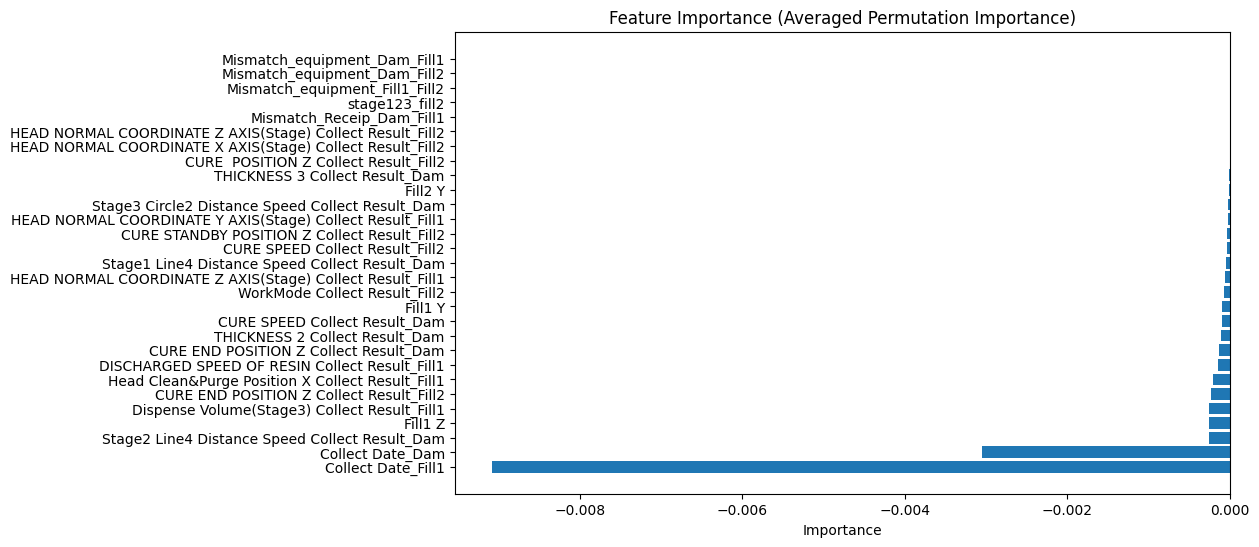

In [378]:
# # Create a DataFrame for easier visualization
# feature_importance_df = pd.DataFrame({
#     'Feature': x_train_cv.columns,
#     'Importance': mean_importances
# })



# # Sort by importance and select top 30 features
# feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True).iloc[-30:-1]

# # Visualize the top 30 feature importances
# plt.figure(figsize=(10, 6))
# plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
# plt.xlabel("Importance")
# plt.title("Feature Importance (Averaged Permutation Importance)")
# plt.gca().invert_yaxis()
# plt.show()

In [379]:
# feature_importance_df = pd.DataFrame({
#     'Feature': x_train_cv.columns,
#     'Importance': mean_importances
# })

# print(feature_importance_df.to_string())

                                                       Feature  Importance
0                                             Collect Date_Dam   -0.003052
1                                       Collect Date_AutoClave    0.019247
2                          Chamber Temp. Judge Value_AutoClave    0.000778
3                                           Collect Date_Fill1   -0.009084
4                                           Collect Date_Fill2   -0.011372
5                                                 Model.Suffix    0.000017
6                                                    Workorder    0.052311
7                                                        Dam X    0.004182
8                                                        Dam Y    0.000202
9                                                        Dam Z    0.000624
10                                                     Fill1 X    0.000033
11                                                     Fill1 Y   -0.000091
12                       

### 언더 샘플링


데이타 불균형을 해결하기 위해 언더 샘플링을 진행합니다.


In [ ]:
# normal_ratio = 1.0  # 1.0 means 1:1 ratio

# df_normal = train_data[train_data["target"] == "Normal"]
# df_abnormal = train_data[train_data["target"] == "AbNormal"]

# num_normal = len(df_normal)
# num_abnormal = len(df_abnormal)
# print(f"  Total: Normal: {num_normal}, AbNormal: {num_abnormal}")

# df_normal = df_normal.sample(n=int(num_abnormal * normal_ratio), replace=False, random_state=RANDOM_STATE)
# df_concat = pd.concat([df_normal, df_abnormal], axis=0).reset_index(drop=True)
# df_concat.value_counts("target")

### 데이터 분할


In [ ]:
# df_train, df_val = train_test_split(
#     df_concat,
#     test_size=0.3,
#     stratify=df_concat["target"],
#     random_state=RANDOM_STATE,
# )


# def print_stats(df: pd.DataFrame):
#     num_normal = len(df[df["target"] == "Normal"])
#     num_abnormal = len(df[df["target"] == "AbNormal"])

#     print(f"  Total: Normal: {num_normal}, AbNormal: {num_abnormal}" + f" ratio: {num_abnormal/num_normal}")


# # Print statistics
# print(f"  \tAbnormal\tNormal")
# print_stats(df_train)
# print_stats(df_val)

## 3. 모델 학습


### 모델 정의


In [ ]:
# model = RandomForestClassifier(random_state=RANDOM_STATE)

### 모델 학습


In [ ]:
# features = []

# for col in df_train.columns:
#     try:
#         df_train[col] = df_train[col].astype(int)
#         features.append(col)
#     except:
#         continue

# train_x = df_train[features]
# train_y = df_train["target"]

# model.fit(train_x, train_y)

## 4. 제출하기


### 테스트 데이터 예측


테스트 데이터 불러오기


In [ ]:
# test_data = pd.read_csv(os.path.join(ROOT_DIR, "test.csv"))

In [ ]:
# df_test_x = test_data[features]

# for col in df_test_x.columns:
#     try:
#         df_test_x.loc[:, col] = df_test_x[col].astype(int)
#     except:
#         continue

In [ ]:
# test_pred = model.predict(df_test_x)
# test_pred

### 제출 파일 작성


In [ ]:
# # 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
# df_sub = pd.read_csv("submission.csv")
# df_sub["target"] = test_pred

# # 제출 파일 저장
# df_sub.to_csv("submission.csv", index=False)

**우측 상단의 제출 버튼을 클릭해 결과를 확인하세요**
